# 0. DATA620: Final Project Proposal - Federal Reserve Sentiment

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

# Setup

## Import Modules

In [1]:
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from textblob import Word

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

import spacy
import spacy.cli
from spacy.lang.en import English

from textatistic import Textatistic
from wordcloud import WordCloud
import statsmodels.api as sm

import networkx as nx
import warnings
from scipy.stats import ttest_ind
plt.rcParams.update({'axes.facecolor':'orange'})
warnings.filterwarnings("ignore")

In [2]:
from textblob import TextBlob
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidsimbandumwe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidsimbandumwe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidsimbandumwe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Global Settings

In [3]:
random.seed(123)
RANDOM_STATE = 123

## Global Functions

In [4]:
# Function that returns average word length
def avg_word_length(x):
    # Split the string into words
    words = x.split()
    # Compute length of each word and store in a separate list
    word_lengths = [len(word) for word in words]
    # Compute average word length
    avg_word_length = sum(word_lengths)/len(words)
    # Return average word length
    return(avg_word_length)


def filter_propn(s):
    
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    
    # Load model and create Doc object
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(s)

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    a_lemmas = [lemma for lemma in lemmas 
                if lemma.isalpha() and lemma not in stopwords]

    a_lemmas = ' '.join(a_lemmas)
    doc_lemmas = nlp(a_lemmas)

    # Generate list of tokens and pos tags
    pos = [(token.text, token.pos_) for token in doc_lemmas]
    
    l = list(zip(*pos))[0]
    l = sorted(set(l))
    
    return ' '.join(l)


def get_city_name(n):
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(n)
    places = [str(ent) for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]

    return ' '.join(places)


# method to trim graph by edge weights
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2 

<br><br>

# Introduction

For most of its 108 year history the deliberations of the federal reserve were cloaked in secrecy and conducted behind closed doors. Successive Federal Reserve Chair believed that the organizations ability to effectively conduct monetary policy relied on it ability to operate behind closed doors. Alan Greenspan expressed this sentiment in his October 11, 2001 speech to the <b>Federal Reserve Bank of St. Louis, Economic Policy Conference.</b>

<blockquote><i>
Human nature being what it is, the vast majority of us are disinclined to offer half-thought-through, but potentially useful, policy notions only to have them embarrassingly dissected in front of a national television audience. When undertaken in such a medium, deliberations tend toward the less provocative and less useful. I do not say that such a system cannot function, but I do say that in my three decades in and out of government, I have never seen it function well.
</i></blockquote>

During his tenure as the Federal Reserve Chair from August 1987 to January 2006 Alan Greenspan was notoriously opaque about federal reserve policy. 


<br>More Recently the Federal Reserve has embarked on an effort to be more transparent. Perhaps non coincidentally this effort corresponds to the recent events when the Fed has been pressed to uses extraordinary measure to prevent economic meltdowns and deep recessions. The next three Fed Chairs have voiced support for institutional transparency. 


<br>Ben Bernanke (Fed Chair February 2006 - January 2014) - in a speech to <b> The Institute for Monetary and Economic Studies International Conference, Bank of Japan, Tokyo, Japan </b>

<blockquote><i>
Transparency regarding monetary policy in particular not only helps make central banks more accountable, it also increases the effectiveness of policy. Clarity about the aims of future policy and about how the central bank likely would react under various economic circumstances reduces uncertainty and--by helping households and firms anticipate central bank actions--amplifies the effect of monetary policy on longer-term interest rates. The greater clarity and reduced uncertainty, in turn, increase the ability of policymakers to influence economic growth and inflation.
</i></blockquote>


<br>Janet Yellen (Fed Chair February 2014-February 2018) in a 2017 speech for the <b> Paul H. Douglas Award for Ethics in Government </b> details how transparency and communication are essential to preventing corruption.




<br>Jerome H. Powell (Fed Chair Since February 2018) in 2018 at <b>Sveriges Riksbank anniversary conference</b>

<blockquote><i>
In a democratic system, any degree of independence brings with it the obligation to provide appropriate transparency. In turn, transparency provides an essential basis for accountability and democratic legitimacy by enabling effective legislative oversight and keeping the public informed.4
</i></blockquote>


<br>The transparency goals of the Fed are clear but have the efforts of the 3 most recent Fed Chairs been successful. Can we demonstrate the level of transparency from the Fed Reserve? How consistent is the messaging leading up to a decision by Federal Reserve Open Market Committee (FOMC)? In this project we will analyze the speeches from the Federal Reserve Board of Governors to determine if the communication leading up to decision by the FOMC provides visibility into the decision. In other words do the communications from Federal Reserve Board of Governors telegraph the actions of the FOMC during their public speeches leading up to FOMC Meeting and the change in the Federal Funds Rate? 



<br><br>

### Background - Federal Reserve System

The Federal Reserve Act, created The Federal Reserve System on December 23, 1913. The Federal Reserve's system has 3 primary components:
- 12 Federal Reserve Banks 
- Federal Reserve Board of Governors
- Federal Open Market Committee

This is a unique structure among central banks in that it includes both public and private characteristics. The division of responsibility across 12 Federal Reserve Banks creates a decentralized system of monetary policy control. 

The Fed has many key functions however its activities can be categorized by the Dual Mandate setup by the Congress in the Federal Reserve Act. 
- maximum employment
- stable prices
The dual mandate is the long-run goal for monetary policy, and the Congress also established the Federal Reserve as an independent agency to help ensure that this monetary policy goal can be achieved.

To support these objectives the federal reserve employs monetary policy through 3 primary mechanisms
- open market operations
- the discount rate
- reserve requirements

To understand the Fed's monitory policy this analysis will focus on the formal decision making process that follow an FOMC Meeting. 



<br><br>

## Hypothesis

In the time leading up FOMC Meeting the Fed Chair and the Governors of the 12 Federal Reserve Banks will develop an economic outlook that will inform their vote at the FOMC Meeting. One way to measure transparency is to evaluate how well this economic outlook is communicated to the general public through speeches. Fortunately for this analysis the Fed tracks all speeches by it board of governors and posts them to www.federalreserve.gov with transcripts.

For this analysis we can categorize the periods between FOMC meeting by their outcome. In each meeting the interest rate target will either be increased, decreased or remain the same. For each type of FOMC meeting outcome we would like to understand if the communication by the representatives of the Fed is consistent and predictable. 

- H0 - Communications by Federal Reserve Board of Governors do not telegraph the outcome of the upcoming FOMC Meeting. There is no measurable difference in speeches by Federal Reserve Board of Governors during periods of increase, decreasing or stable interest rates. 

- H1 - Federal Reserve Board of Governors will telegraph the outcome of the upcoming FOMC Meeting through their communications. The speeches by Federal Reserve Board of Governors will differ predictably during periods of increase, decreasing or stable interest rates.  

<br>

# 2. Workflow

For the purpoase of this analysis we will employed the OSEMN workflow. This workflow has five phases: Obtain, Scrub, Explore, Model, and iNterpret.

## Obtain

The first step in the process is obtainig that data for the analysis. We used a combination of prepackaged data from Kaggle, original source data from the Federal Reserve and summary data from aggregator sites.

* Federal Reserve - https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm
* Aggregator (The Balance) - https://www.thebalance.com/fed-funds-rate-history-highs-lows-3306135
* Kaggle - https://www.kaggle.com/datasets/natanm/federal-reserve-governors-speeches-1996-2020?resource=download

<br>

### Data Source
There are several sources of prepossessed data from the Fed Reserve speeches and FOMC Meeting outcomes, however it might be necessary to augment these data set to get the latest information. For the purposes of this analysis we will create two unique data sets. 

1. Aggregate FOMC Decisions - the outcome of each FOMC meeting is captured in a broader write-up however the decision can be distilled into meeting date, meeting location, decision to increase, decrease or leave interested unchanged, and a magnitude of the change, and the new target range for interest rates
2. Aggregate Speeches by FOMC Members - Each member of the FOMC maintains a detailed calendar of speeches that includes, location, audience, speech title, speech text.

The ability to forecast result of an FOMC meeting can generate significant financial gains as a result there is a large body of work analyzing the topic, using a variety of methods. 

<br>

### FOMC Fed Rate Decision (events)

The Federal Open Market Committee meets a minimum of 8 times a year in regularly scheduled sessions. During these sessions the representatives from the Federal Reserve member banks will discuss their economic outlook. At the conclusion of each meeting the member of FOMC will reach consensus on a monetary policy decision. The data set below captures the result of the FOMC meetings since May 1987.

In [5]:
# load FOMC decision
decision_df = pd.read_csv('data/Manual_Event.csv')

<br>

### Federal Reserve Members Communications (speeches)

The speeches by Federal Reserve Members are captured in the following dataframe. The data set is also cleaned up for stop words and custom stop words.

In [6]:
# load speeches
speech_df = pd.read_csv('data/fed_speeches_1996_2020.csv', parse_dates=['speech_date'] , encoding='utf_8')

<br>

## Scrub

The filtration process to standardize format for modeling start with reviewing speech data including its metadata and meeting data that includes the decision and the magnitude of the rate change. 


### FOMC Fed Rate Decision (events)



In [7]:
decision_df['event_date']  = pd.to_datetime(decision_df['event_date'])
decision_df['date_diff'] = decision_df['event_date'].diff()
decision_df['start_date'] = decision_df['event_date'] - decision_df['date_diff']
decision_df['end_date'] = decision_df['event_date']
decision_df['event_id'] = 'E' + decision_df.index.astype(str)
decision_df = decision_df.drop(['id'], axis=1)
decision_df.head()

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id
0,1987-05-19,0.0650,increase,0.0062,Paul Volcker,Continued raising rates to fight inflation,NaT,NaT,1987-05-19,E0
1,1987-07-07,0.0650,no change,0.0000,Alan Greenspan,- no change -,49 days,1987-05-19,1987-07-07,E1
2,1987-08-18,0.0650,no change,0.0000,Alan Greenspan,- no change -,42 days,1987-07-07,1987-08-18,E2
3,1987-09-22,0.0725,increase,0.0075,Alan Greenspan,No notable event,35 days,1987-08-18,1987-09-22,E3
4,1987-11-04,0.0681,decrease,-0.0044,Alan Greenspan,Lowered after Black Monday stock market crash,43 days,1987-09-22,1987-11-04,E4


<br>

### Federal Reserve Member Communications (speeches)

In [8]:
# filter out some garbage records
speech_df = speech_df[speech_df['text_len'] > 50]
speech_df['year'] = speech_df['year'].astype(int)
speech_df['speaker'].value_counts(sort=True)

Chairman Alan Greenspan                         183
Chairman Ben S. Bernanke                        169
Vice Chairman Roger W. Ferguson                  96
Governor Susan S. Bies                           77
Governor Lael Brainard                           68
Governor Laurence H. Meyer                       65
Governor Edward M. Gramlich                      59
Governor Daniel K. Tarullo                       54
Governor Jerome H. Powell                        50
Vice Chairman Donald L. Kohn                     46
Governor Mark W. Olson                           46
Vice Chairman Stanley Fischer                    45
Governor Ben S. Bernanke                         45
Governor Randall S. Kroszner                     44
Governor Elizabeth A. Duke                       44
Chair Janet L. Yellen                            44
Vice Chair for Supervision Randal K. Quarles     39
Chairman Jerome H. Powell                        32
Governor Donald L. Kohn                          30
Governor Rog

In [9]:
# remove stop words from text
stop_words = set(stopwords.words('english')) 
custom_stopwords = set(('chairman','chair','alan','greenspan','ben','bernanke','janet', 'yellen','jerome','powell',',',' ','.', ';', '?', '-', '!', '(', ')','--','"',"'", ':', '¡¦', '¡','', '9', '/'))

# process text
speech_df['speech_id'] = 'S' + speech_df.index.astype(str)
speech_df['text'] = speech_df['text'].str.lower()
speech_df['filter_text'] = speech_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))
speech_df['filter_text'] = speech_df['filter_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
speech_df['filter_text'] = speech_df['filter_text'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
speech_df['filter_text_len'] = speech_df['filter_text'].apply(lambda x: len(x.split()))
speech_df['avg_word_length_filter'] = speech_df['filter_text'].apply(avg_word_length)
speech_df.head()

,link,title,speaker,event,year,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter
0,https://www.federalreserve.gov/boarddocs/speec...,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,1996,i discovered when i joined the board of govern...,1996-12-19,3671,D.C.,S0,discovered joined board governor federal reser...,2092,7.125717
1,https://www.federalreserve.gov/boarddocs/speec...,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996,i am privileged to accept the union league of...,1996-12-06,2596,Pennsylvania,S1,privileged accept union league philadelphia's ...,1551,6.969697
2,https://www.federalreserve.gov/boarddocs/speec...,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996,the challenge of central banking in a democrat...,1996-12-05,4344,D.C.,S2,challenge central banking democratic society g...,2379,7.200504
3,https://www.federalreserve.gov/boarddocs/speec...,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",1996,it is a pleasure to be with you this morning ...,1996-12-03,2527,D.C.,S3,pleasure morning discus private-sector payment...,1488,7.305780
4,https://www.federalreserve.gov/boarddocs/speec...,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,1996,supervisory and regulatory responses to financ...,1996-11-25,2222,D.C.,S4,supervisory regulatory response financial inno...,1281,7.597970


<br>

### merge speech and FOMC Meeting (events)

By merging the event and the speech data frames we can associate each speech with a period and FOMC action.

In [10]:
# merge dataframes by speech date and decisoin period
df_merge = decision_df.merge(speech_df, how='cross')
df_merge = df_merge.query('speech_date > start_date and speech_date <= end_date')

# calc speech weights as distance between speech and FOMC meeting
df_merge['days_before'] = df_merge['end_date'] - df_merge['speech_date']
df_merge['days_before'] = df_merge['days_before'].apply(lambda x: x.days)
df_merge.loc[df_merge["days_before"] == 0, "days_before"] = 0.1
df_merge['weight'] = 1 / df_merge['days_before']

df_merge.head(5)

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id,...,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter,days_before,weight
121649,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,"remarks by governor edward w. kelley, jr. deve...",1996-06-18,2635,Texas,S17,"remark governor edward w. kelley, jr. developm...",1536,7.205078,15.0,0.066667
121650,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,remarks by chairman alan greenspan bank superv...,1996-06-13,3164,Sweden,S18,remark bank supervision world economy internat...,1837,7.357104,20.0,0.050000
124543,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,remarks by chairman alan greenspan regulation ...,1996-09-19,1948,D.C.,S15,remark regulation electronic payment system u....,1132,7.118375,5.0,0.200000
124544,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,monetary policy objectives and strategy i wan...,1996-09-08,2633,Massachusetts,S16,monetary policy objective strategy want share ...,1441,6.927828,16.0,0.062500
125983,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,the future of electronic payments i am del...,1996-10-31,2449,New York,S7,future electronic payment delighted morning di...,1423,6.907238,13.0,0.076923


<br><br>

## Explore

<br>

### FOMC Fed Rate Decision (events)

The following graph anayzes the FOMC actions by Meeting outcome. The rates of activity are not consistent. No action or holding interest rates stable is by far the most prominent outcome in the dataset. 

In [11]:
decision_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   event_date   302 non-null    datetime64[ns] 
 1   fed_rate     302 non-null    float64        
 2   action       302 non-null    object         
 3   rate_change  302 non-null    float64        
 4   fed_chair    302 non-null    object         
 5   notes        302 non-null    object         
 6   date_diff    301 non-null    timedelta64[ns]
 7   start_date   301 non-null    datetime64[ns] 
 8   end_date     302 non-null    datetime64[ns] 
 9   event_id     302 non-null    object         
dtypes: datetime64[ns](3), float64(2), object(4), timedelta64[ns](1)
memory usage: 23.7+ KB


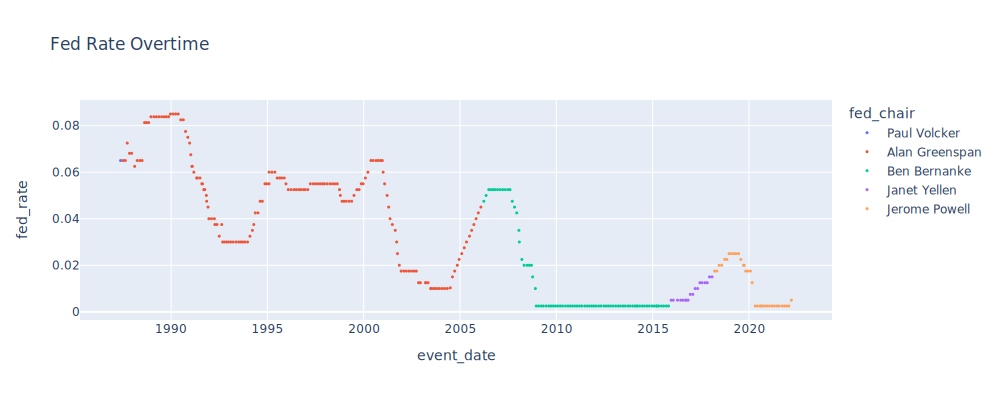

In [12]:
fig = px.scatter(data_frame=decision_df, 
                x='event_date', y='fed_rate', 
                color="fed_chair", 
                width=1000, height=400, 
                title='Fed Rate Overtime',
            )

fig.update_traces(marker_size=3)

fig.show(renderer='svg')

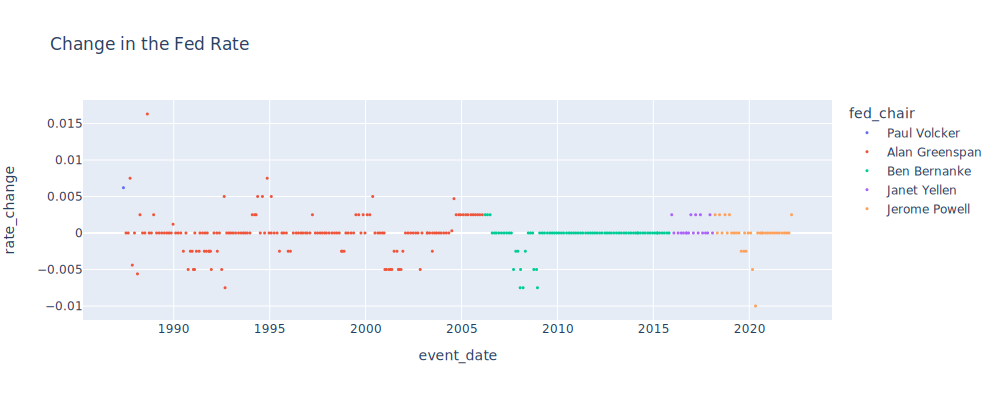

In [13]:
fig = px.scatter(data_frame=decision_df, 
                x='event_date', y='rate_change', 
                color="fed_chair", 
                width=1000, height=400, 
                title='Change in the Fed Rate',   
            )

fig.update_traces(marker_size=3)

fig.show(renderer='svg')

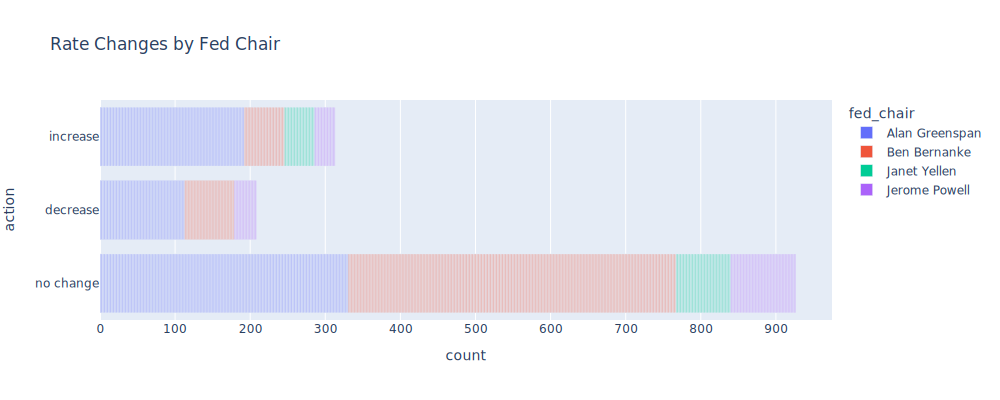

In [14]:
fig = px.bar(df_merge, y="action", color='fed_chair', orientation='h',
             hover_data=["action", "rate_change"],
             width=1000, height=400, 
             title='Rate Changes by Fed Chair')
fig.show(renderer='svg')

<br>

### Federal Reserve Chairman Communications (speeches)

In [15]:
speech_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1455
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   link                    1448 non-null   object        
 1   title                   1448 non-null   object        
 2   speaker                 1446 non-null   object        
 3   event                   1448 non-null   object        
 4   year                    1448 non-null   int64         
 5   text                    1448 non-null   object        
 6   speech_date             1447 non-null   datetime64[ns]
 7   text_len                1448 non-null   int64         
 8   location                1448 non-null   object        
 9   speech_id               1448 non-null   object        
 10  filter_text             1448 non-null   object        
 11  filter_text_len         1448 non-null   int64         
 12  avg_word_length_filter  1448 non-null   float64 

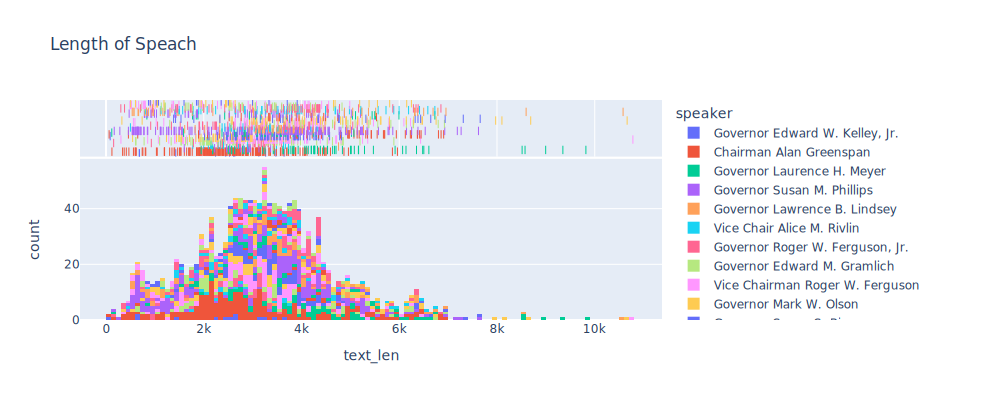

In [16]:
df = df_merge.dropna(subset=['text_len','speaker'])

fig = px.histogram(df, x="text_len", marginal="rug", color='speaker', nbins=150, hover_data=['speaker','title']
                  ,title="Length of Speach", width=1000, height=400)
fig.show(renderer='svg')

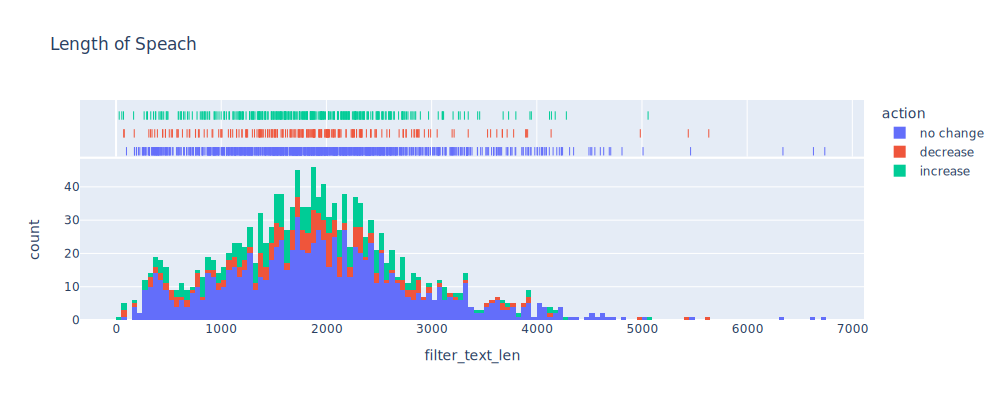

In [17]:
fig = px.histogram(df_merge, x="filter_text_len", color='action' ,marginal="rug",nbins=150, hover_data=['speaker','title']
                  ,title="Length of Speach", width=1000, height=400)
fig.show(renderer='svg')

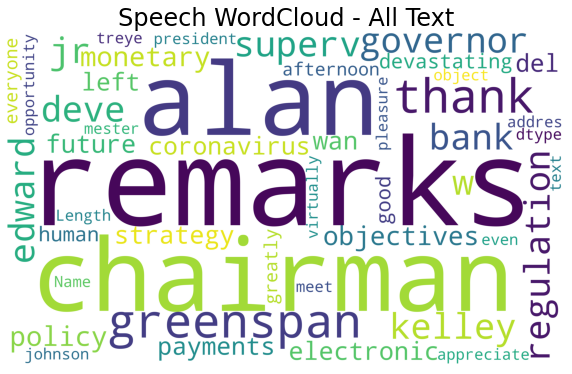

In [18]:
text = str(df_merge['text'])
title = 'Speech WordCloud - All Text'

w = text.split()

words = ' '.join(w)

wordcloud = WordCloud(
                  background_color='white',
                  width=5000,
                  height=3000
                 ).generate(words)
plt.figure(1,figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(title, fontsize=24)
plt.show()

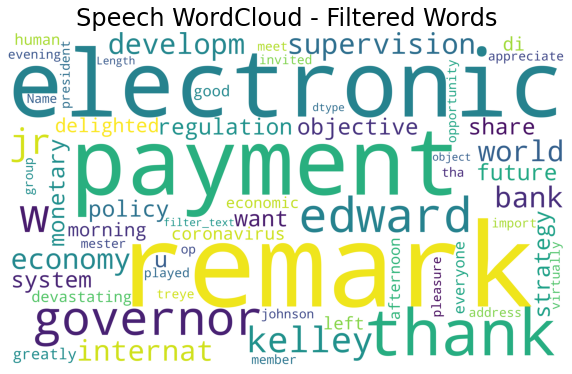

In [19]:
text = str(df_merge['filter_text'])
title = 'Speech WordCloud - Filtered Words'

w = text.split()

words = ' '.join(w)

wordcloud = WordCloud(
                  background_color='white',
                  width=5000,
                  height=3000
                 ).generate(words)
plt.figure(1,figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(title, fontsize=24)
plt.show()

<br>

### merge speech and FOMC Meeting (events)

We can use a network graph to visualize the relationship between individual speeches and the results of the FOMC decision making process. The network graph below highlights the association of speeches in a given period to the FOMC rate decision, with the weights representing the number of days prior to the decision that the speech was made.

In [20]:
# filter dataset
#df = df_merge
#df = df_merge[df_merge['speaker'] == 'Chairman Jerome H. Powell']
df = df_merge[df_merge['speaker'] == 'Chairman Alan Greenspan']


# create the graph with the two node types
B = nx.Graph()
B.add_nodes_from(df['rate_change'], bipartite=0)
B.add_nodes_from(df['speech_id'], bipartite=1)

# add the weights
tuples = df[['rate_change','speech_id','weight']].to_numpy()
B.add_weighted_edges_from(tuples, weight='weight')

# test to see if the graph is connected
print('We confirm that connected status of the graph. Graph connected status:',nx.is_connected(B))

# verify that a bipartite graph was created
print('We also confirmed that the the graph is a bipartite graph. Graph bipartite status:',nx.is_bipartite(B))

# create node lists for each node type
rate_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
speech_nodes = set(B) - rate_nodes

We confirm that connected status of the graph. Graph connected status: False
We also confirmed that the the graph is a bipartite graph. Graph bipartite status: True


In [21]:
# variable for the target weight
filter_weight = 0.048       
filter_B = trim_edges(B,filter_weight) 

<Figure size 1080x720 with 0 Axes>

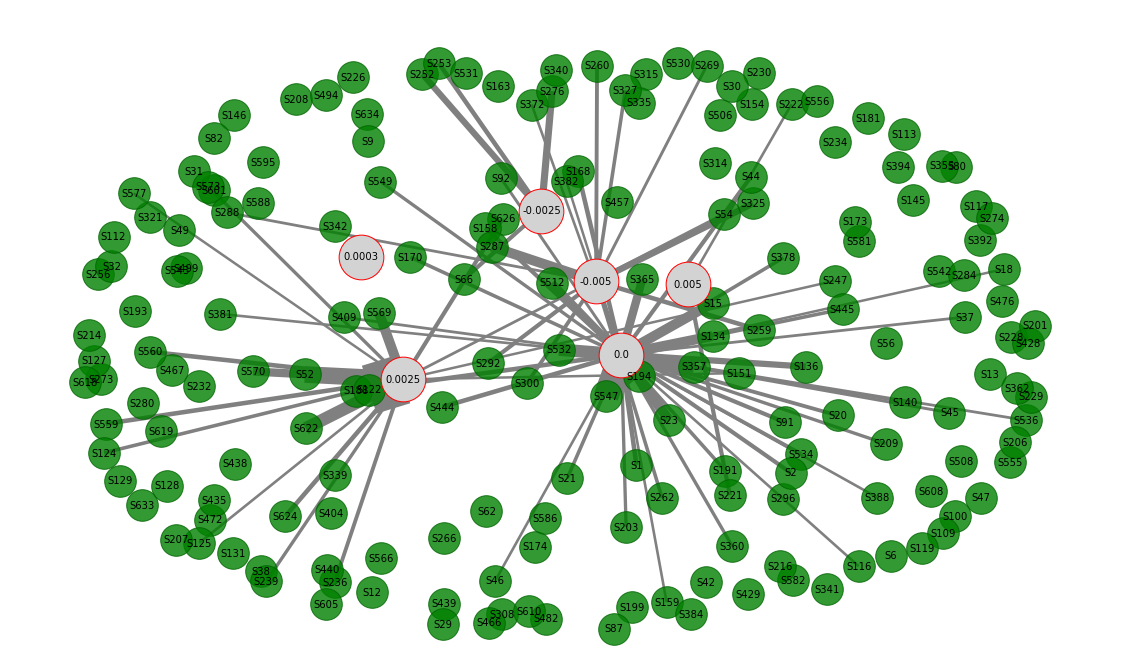

In [22]:
plt.figure(figsize = (15,10))
pos = nx.spring_layout(B, seed=34, k=0.2)
#pos = nx.random_layout(filter_B)
#pos = nx.shell_layout(filter_B)
#pos = nx.bipartite_layout(filter_B,rate_nodes)

fig, ax = plt.subplots(figsize = (20,12))


edge_labels = nx.get_edge_attributes(filter_B, 'weight')
edge_w = np.array(list(edge_labels.values())) * 50


#topic = weighted_2mode['Topic']
nx.draw_networkx_nodes(B,pos,
                       nodelist=speech_nodes,
                       node_color='green',
                       node_size=1000,
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_nodes(B,pos,
                       nodelist=rate_nodes,
                       node_color='lightgray',
                       node_size=2000,
                       edgecolors='red',
                       alpha=1)

nx.draw_networkx_edges(filter_B, pos,
                       edge_color='gray',
                       width=edge_w, 
                       #edge_color=edge_w,
                      )


ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')
_0 = nx.draw_networkx_labels(B, pos, font_size=10)

In [23]:
#df_merge[df_merge['weight'] > 0.048].sort_values('days_before', ascending=False)

Additional avenues of analysis could include the impact of time on the ability of a speech to accurately predict the outcome of the FOMC Meeting. One can assume that the economic outlook might change over the period between FOMC meetings with the consensus outlook directly prior to the meeting representing the best assessment of the Board of governors positioning on monitory policy. 

<br><br>

## Rule Based Approach Sentiment Analysis

Rule based sentiment analysis uses predefined lexicons to generate a sentiment score. The TextBlob library has predetermined rules stored in word and weight dictionaries that can be leveraged to generate polarity and subjectivity scores.
   * Polarity: Defines the sentiment of the text (-1 is extremely negative, 1 is extremely positive)
   * Subjectivity: Quantifies the amount of personal opinion and factual information contained in the text (closer to 0 indicates more factual information, closer to 1 indicates the text contains more personal opinion) 
   
We applied this approach to the filtered text to try to understand the sentiment of the speeches across several federal chair members. We also wanted to see if different language was used in different voting actions made by the Federal Open Market Committee. Lastly, we check to see the subjectivity of each speech and if there were any patterns under a particular federal chair member.

In [24]:
# function to calculate subjectivity
def getSubjectivity(speech):
    return TextBlob(speech).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(speech):
    return TextBlob(speech).sentiment.polarity

# function to analyze the reviews
def analysis_polarity(score):
    if score < -0.05:
        return 'Negative'
    if score > 0.05:
        return 'Positive'
    elif score >= -0.05 and score <= 0.05 :
        return 'Neutral'
    
def analysis_subjectivity(score):
    if score < 0.4:
        return 'Objective'
    if score > 0.6:
        return 'Subjective'
    else:
        return 'Balanced'

In [25]:
sentiment_df = df_merge.copy()
fin_data = pd.DataFrame(sentiment_df[['text', 'filter_text']])

fin_data['Polarity'] = fin_data['filter_text'].apply(getPolarity) 
fin_data['Subjectivity'] = fin_data['filter_text'].apply(getSubjectivity) 
fin_data['AnalysisPol'] = fin_data['Polarity'].apply(analysis_polarity)
fin_data['AnalysisSub'] = fin_data['Subjectivity'].apply(analysis_subjectivity)
fin_data.head()

,text,filter_text,Polarity,Subjectivity,AnalysisPol,AnalysisSub
121649,"remarks by governor edward w. kelley, jr. deve...","remark governor edward w. kelley, jr. developm...",0.123308,0.444044,Positive,Balanced
121650,remarks by chairman alan greenspan bank superv...,remark bank supervision world economy internat...,0.115051,0.445730,Positive,Balanced
124543,remarks by chairman alan greenspan regulation ...,remark regulation electronic payment system u....,0.127887,0.490485,Positive,Balanced
124544,monetary policy objectives and strategy i wan...,monetary policy objective strategy want share ...,0.094618,0.377058,Positive,Objective
125983,the future of electronic payments i am del...,future electronic payment delighted morning di...,0.086364,0.397455,Positive,Objective


<br>

#### Polarity and Subjectivity Counts

The following thresholds were create to determine polarity and subjectivity labels:
* Polarity
    - Positive: score > 0.05
    - Negative: score < -0.05
    - Neutral: score is between -0.05 and 0.05
* Subjectivity
    - Objective: score < 0.4
    - Subjective: score > 0.6
    - Balanced: score is between 0.4 and 0.6
    
We found that most of the sentiment was positive (94.3 %). And only 1 speech had an overall negative tone. 

The subjectiveness of the speeches was also fairly skewed as there were only 2 subjective speeches out of the 1466 speeches in the dataset. Most were balanced, incorporating both opinion and factual information.

In [26]:
pol_counts = fin_data.AnalysisPol.value_counts()
pol_counts

Positive    1366
Neutral       80
Negative       1
Name: AnalysisPol, dtype: int64

In [27]:
sub_counts = fin_data.AnalysisSub.value_counts()
sub_counts

Balanced      753
Objective     692
Subjective      2
Name: AnalysisSub, dtype: int64

<br>

### Visualizations 

In [28]:
sentiment_df1 = sentiment_df.merge(fin_data, how='inner')

<br>

#### Data Distributions

The polarity score distribution apears to be near normal with a mean around 0.1, indicating that most of the speeches are positive in sentiment.

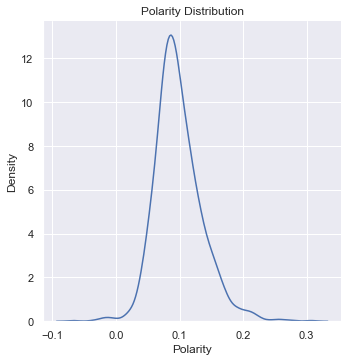

In [29]:
sns.set(rc = {'figure.figsize':(12,8)})

sns.displot(data=sentiment_df1, x='Polarity', kind="kde")
plt.title('Polarity Distribution')
plt.show()

The subjectivity score distribution also appears to be near normal with a mean close to 0.4, showing that most data values are both Balanced and Objective.

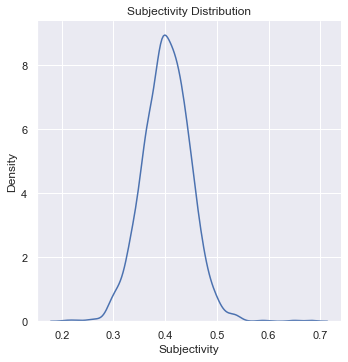

In [30]:
sns.displot(data=sentiment_df1, x='Subjectivity', kind="kde")
plt.title('Subjectivity Distribution')
plt.show()

<br>

#### Polarity

#### Polarity vs. Voting Action

We found that polarity score is about equal across all the group in `action`. Though it should be noted that 'increase' and 'no change' have a fair amount of variablity.

<AxesSubplot:xlabel='action', ylabel='Polarity'>

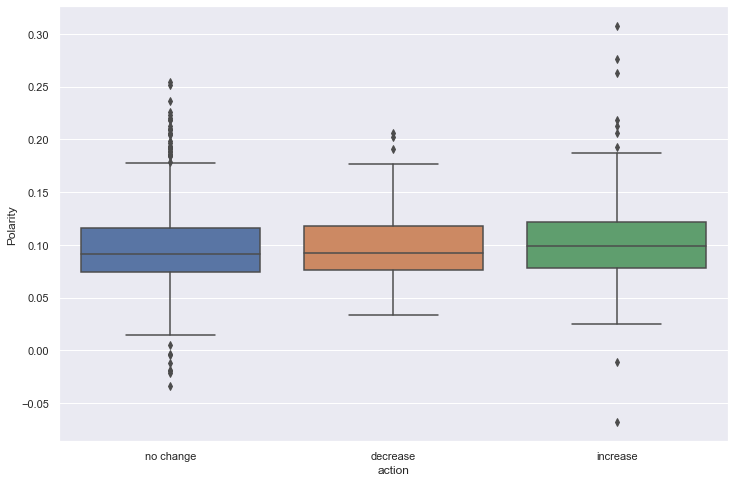

In [31]:
sns.boxplot(x="action", y="Polarity", data=sentiment_df1)

In [32]:
sentiment_df1.groupby('action')['Polarity'].mean()

action
decrease     0.098589
increase     0.102266
no change    0.096899
Name: Polarity, dtype: float64

#### Polarity vs. Federal Chair Member

The speeches under the federal chairs' sentiment score is displayed below. Alan Greenspan and Ben Bernanke display similar sentiment scores throughout their terms. Janet Yellen has a tightest spread of sentiment score compared to her counterparts. Jerome Powell has the highest general sentiment score across all speeches.

<AxesSubplot:xlabel='fed_chair', ylabel='Polarity'>

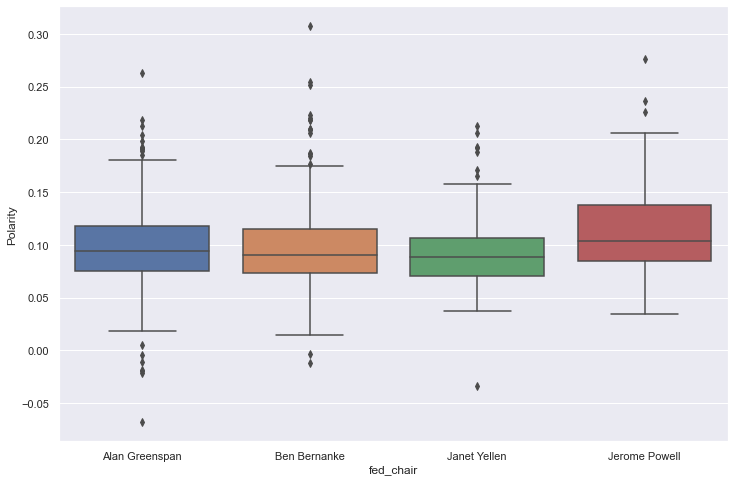

In [33]:
sns.boxplot(x="fed_chair", y="Polarity", data=sentiment_df1)

In [34]:
sentiment_df1.groupby('fed_chair')['Polarity'].mean()

fed_chair
Alan Greenspan    0.097449
Ben Bernanke      0.096672
Janet Yellen      0.093155
Jerome Powell     0.112795
Name: Polarity, dtype: float64

<br>

#### Subjectivity

#### Subjectivity vs.  Voting Action

The subjectivity score appears to be equal across the voting decision actions. Interestingly the `action`, 'decrease', contributed to 100% of the subjective speeches. 

<AxesSubplot:xlabel='action', ylabel='Subjectivity'>

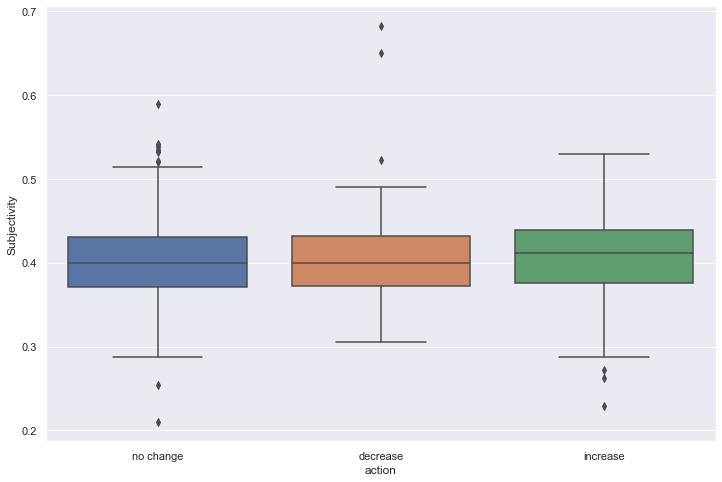

In [35]:
sns.boxplot(x="action", y="Subjectivity", data=sentiment_df1)

In [36]:
sentiment_df1.groupby('action')['Subjectivity'].mean()

action
decrease     0.404198
increase     0.408159
no change    0.400725
Name: Subjectivity, dtype: float64

<br>

#### Subjectivity vs. Federal Chair Member

The federal chair members' subjectivity score appears to be slightly different between the chair members. Alan Greenspan had the most subjective speeches, followed by Ben Bernanke, then Janet Yellen, and finally Jerme Powell with the most objective speeches. Greenspan also had the only two extremely subjective speeches.  

<AxesSubplot:xlabel='fed_chair', ylabel='Subjectivity'>

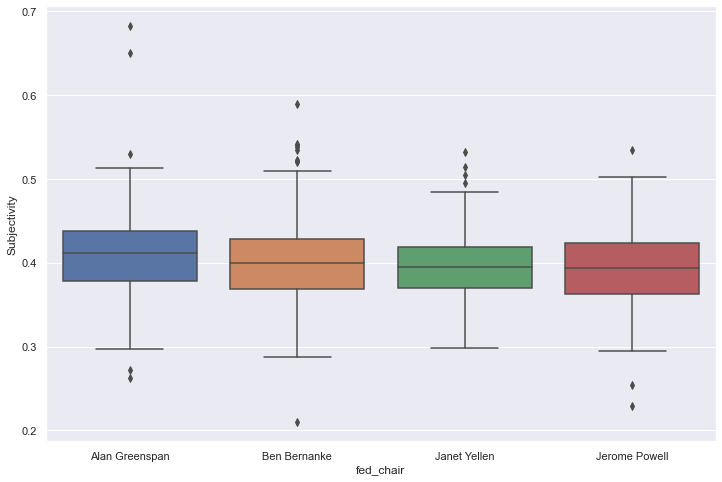

In [37]:
sns.boxplot(x="fed_chair", y="Subjectivity", data=sentiment_df1)

In [38]:
sentiment_df1.groupby('fed_chair')['Subjectivity'].mean()

fed_chair
Alan Greenspan    0.408625
Ben Bernanke      0.399342
Janet Yellen      0.398146
Jerome Powell     0.393967
Name: Subjectivity, dtype: float64

<br><br>

## Model

### Predict FOMC Rate Decision (Naive Bayes Sentiment Analysis)

Naive Bayes is a simplified technique for constructing classifiers. The models assume feature independence for a given class variable. This is contradictory to the construction of speech where the elements of the speech are thematically and logically connected but is a useful place to start the analysis.

#### Fed Chair Alan Greenspan

Alan Greenspan was appointed by Ronald Reagan and was Fed Chair from August 11, 1987 to January 31, 2006. Over his 18 years presiding over the fed he gave 183 speeches that were recorded on the Fed Web Site. This represents by far the greatest volume of speeches. 

In [39]:
greenspan_df = df_merge[df_merge['fed_chair'] == 'Alan Greenspan']
greenspan_df['speaker'].value_counts(sort=True)

Chairman Alan Greenspan            183
Vice Chairman Roger W. Ferguson     90
Governor Laurence H. Meyer          65
Governor Edward M. Gramlich         59
Governor Susan S. Bies              59
Governor Ben S. Bernanke            45
Governor Mark W. Olson              40
Governor Roger W. Ferguson, Jr.     27
Governor Donald L. Kohn             24
Vice Chair Alice M. Rivlin          17
Governor Edward W. Kelley, Jr.      12
Governor Susan M. Phillips          12
Governor Lawrence B. Lindsey         3
Name: speaker, dtype: int64

<br><br>

When compaired to the tenures of the next 3 Fed Chairs Alan Greenspan's time as Fed Chair represented a level of normalcy with respect to the Federal Funds rate and the associated monitory policy. Even with this more normal movement of interest rates the graph below highlight the unbalanced nature of FOMC decision making process. No Change in interest rates is the more common result of the FOMC meetings.  

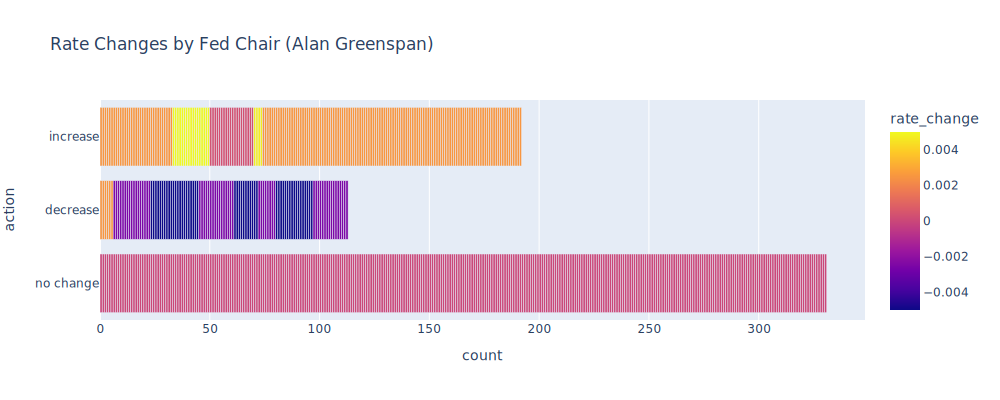

In [40]:
fig = px.bar(greenspan_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             width=1000, height=400,
             title='Rate Changes by Fed Chair (Alan Greenspan)')
fig.show(renderer='svg')

The bar-chart above highlights the imbalanced nature of the FOMC decision dataset. To mitigate the impacts of this imbalance we will use a RandomUnderSampler to equalize the number of samples in all the classes before the training.

1. Split the dataset into training and testing
2. initialize a vectorizer to create the BoW
3. Initialize a imbalanced pipeline with the vectorizer, random sampler, and model
4. Fit the model
5. Generate measurements of model accuracy on the Training dataset
6. Predict Testing dataset
7. Generate measurement of model accuracy on the Test dataset

In [41]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['action'], random_state=23, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# define vectorizer and model pipeline
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())

_none = model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 232, 'increase': 130, 'decrease': 83})
Testing target statistics: Counter({'no change': 99, 'increase': 62, 'decrease': 30})


In [42]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.4444 0.5111 0.2667 0.4889 0.4    0.4545 0.4318 0.5682 0.4545 0.5227]
Average 10-Fold CV Score: 0.4543


[[ 6  6 18]
 [14 14 34]
 [14 13 72]]


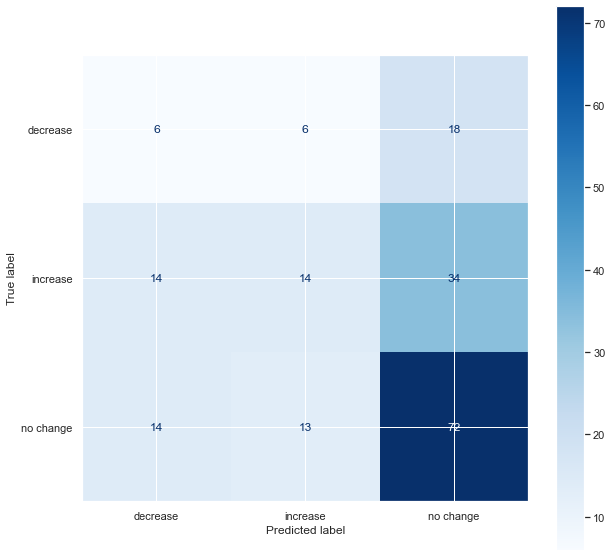

In [43]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [44]:
greenspan_imb_cl = classification_report_imbalanced(y_test, y_pred, digits=4)
print(greenspan_imb_cl)

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.1765    0.2000    0.8261    0.1875    0.4065    0.1549        30
   increase     0.4242    0.2258    0.8527    0.2947    0.4388    0.1805        62
  no change     0.5806    0.7273    0.4348    0.6457    0.5623    0.3255        99

avg / total     0.4664    0.4817    0.6319    0.4598    0.4977    0.2516       191



Key results to highlight from the confusion matrix and classification report:
* overall precision is low with only 0.467 accuracy
* given the structure of the decision making process unsurprisingly no change is the most accurate class
* Specificity was relatively high for decrease and the increase class. the model was able to accurately predict true negatives

In [45]:
df_merge.head()

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id,...,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter,days_before,weight
121649,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,"remarks by governor edward w. kelley, jr. deve...",1996-06-18,2635,Texas,S17,"remark governor edward w. kelley, jr. developm...",1536,7.205078,15.0,0.066667
121650,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,remarks by chairman alan greenspan bank superv...,1996-06-13,3164,Sweden,S18,remark bank supervision world economy internat...,1837,7.357104,20.0,0.050000
124543,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,remarks by chairman alan greenspan regulation ...,1996-09-19,1948,D.C.,S15,remark regulation electronic payment system u....,1132,7.118375,5.0,0.200000
124544,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,monetary policy objectives and strategy i wan...,1996-09-08,2633,Massachusetts,S16,monetary policy objective strategy want share ...,1441,6.927828,16.0,0.062500
125983,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,the future of electronic payments i am del...,1996-10-31,2449,New York,S7,future electronic payment delighted morning di...,1423,6.907238,13.0,0.076923


In [46]:
set(df_merge['fed_chair'])

{'Alan Greenspan', 'Ben Bernanke', 'Janet Yellen', 'Jerome Powell'}

In [47]:
a_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
a_cl_df['fed_chair'] = 'Alan Greenspan'
a_cl_df['model'] = 'Model 1: Naive Bayes'

In [48]:
cl_result_df = a_cl_df.copy()

<br>

#### Fed Chair Ben S. Bernanke
Ben Bernanke was appointed by George W. Bush and was Fed Chair from February 1, 2006 to January 31, 2014. He served as Fed Chair during a trying economic time for the global financial system and this was reflected in the Fed Funds rate movement during his tenure. For the majority of his term as Fed chair rates were effectively zero and the Fed resorted to extra ordinary action to enact its monitory policy. It should be noted that even though Ben Bernanke's term as Fed Chair was almost 10 years shorter than Alan Greenspan's, Bernanke only had 18 fewer speeches. 

In [49]:
ben_df = df_merge[df_merge['fed_chair'] == 'Ben Bernanke']
ben_df['speaker'].value_counts(sort=True)

Chairman Ben S. Bernanke           169
Vice Chairman Donald L. Kohn        46
Governor Daniel K. Tarullo          45
Governor Elizabeth A. Duke          44
Governor Randall S. Kroszner        43
Governor Frederic S. Mishkin        27
Governor Jerome H. Powell           24
Chair Janet L. Yellen               23
Vice Chair Janet L. Yellen          22
Governor Susan S. Bies              18
Governor Kevin Warsh                18
Governor Sarah Bloom Raskin         17
Governor Jeremy C. Stein            16
Vice Chairman Stanley Fischer       15
Governor Lael Brainard               9
Vice Chairman Roger W. Ferguson      6
Governor Donald L. Kohn              6
Governor Mark W. Olson               6
Name: speaker, dtype: int64

<br>

The long period of zero effective interest rates are reflected in the bar graph below. The FOMC decision dataset for Ben Bernanke exhibits even more imbalance when compared to the Alan Greenspan tenure.

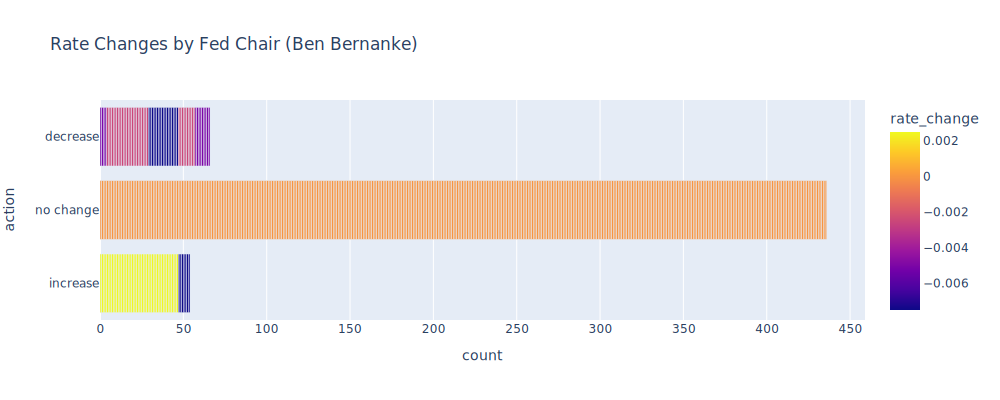

In [50]:
fig = px.bar(ben_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             width=1000, height=400, 
             title='Rate Changes by Fed Chair (Ben Bernanke)')
fig.show(renderer='svg')

The analysis for Ben Bernanke's tenure follows the same structure as the previous analysis.

In [51]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['action'], random_state=RANDOM_STATE, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
_none = model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 308, 'decrease': 43, 'increase': 38})
Testing target statistics: Counter({'no change': 128, 'decrease': 23, 'increase': 16})


In [52]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)

print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.4872 0.4872 0.4615 0.2821 0.4359 0.641  0.7179 0.5385 0.5641 0.5263]
Average 10-Fold CV Score: 0.5142


[[20  0  3]
 [ 3  9  4]
 [44 11 73]]


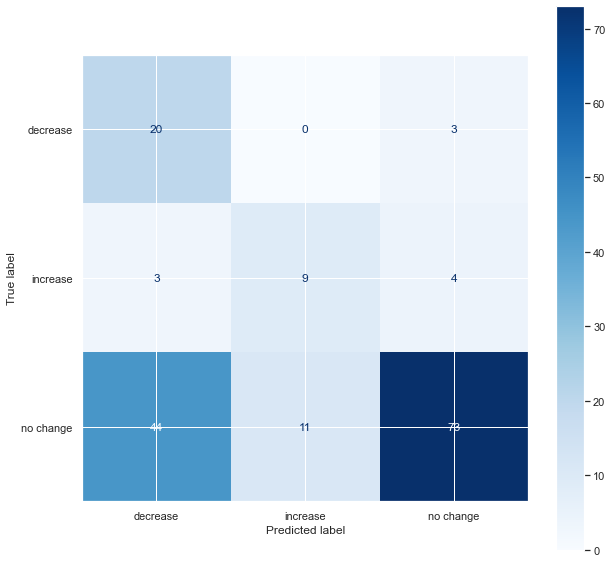

In [53]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [54]:
bernanke_imb_cl = classification_report_imbalanced(y_test, y_pred, digits=4)
print(bernanke_imb_cl)

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.2985    0.8696    0.6736    0.4444    0.7653    0.5972        23
   increase     0.4500    0.5625    0.9272    0.5000    0.7222    0.5025        16
  no change     0.9125    0.5703    0.8205    0.7019    0.6841    0.4562       128

avg / total     0.7836    0.6108    0.8105    0.6471    0.6989    0.4801       167



<br>

The precision of the Naive Bayes model is significantly better during the Ben Bernanke tenure as Fed Chair. Key highlights include
* precision for the no change class is over 0.900
* recall follows the exact opposite pattern to precision with the decrease class exhibits the highest accuracy.
* specificity or the true negative rate is higher across all classes

In [55]:
b_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
b_cl_df['fed_chair'] = 'Ben Bernanke'
b_cl_df['model'] = 'Model 1: Naive Bayes'

In [56]:
cl_result_df = pd.concat([cl_result_df, b_cl_df])

<br>

#### Fed Chair Janet L. Yellen

Janet Yellen was appointed by Barack Obama and was Fed Chair from February 3, 2014 to February 3, 2018. She served only a 4 year term. This limited term is reflected in the number of speeches included in the associated dataset.


In [57]:
yellen_df = df_merge[df_merge['fed_chair'] == 'Janet Yellen']
yellen_df['speaker'].value_counts(sort=True)

Vice Chairman Stanley Fischer                   30
Governor Jerome H. Powell                       26
Governor Lael Brainard                          25
Chair Janet L. Yellen                           21
Governor Daniel K. Tarullo                       9
Vice Chair for Supervision Randal K. Quarles     2
Name: speaker, dtype: int64

<br>

Janet Yellen's tenure as Fed Chair was punctuated by a return to normalcy in the financial markets and the resulting Fed Monitory Policy. Unsurprisingly this period is more balanced and only included no change classes and increases in the Federal Funds Rate. 

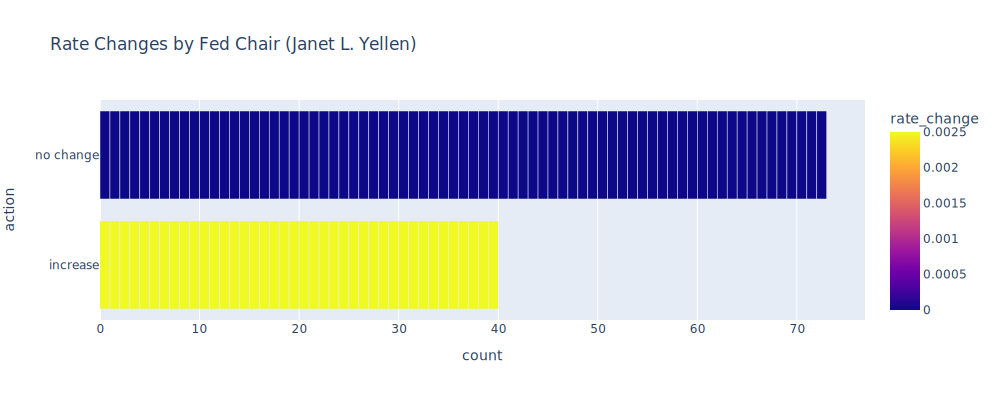

In [58]:
fig = px.bar(yellen_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             width=1000, height=400, 
             title='Rate Changes by Fed Chair (Janet L. Yellen)')
fig.show(renderer='svg')

The analysis for Janet Yellen's tenure follows the same structure as the previous analysis.

In [59]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(yellen_df['filter_text'], yellen_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 45, 'increase': 34})
Testing target statistics: Counter({'no change': 28, 'increase': 6})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [60]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.5    0.25   0.375  0.625  0.375  0.5    0.375  0.5    0.375  0.5714]
Average 10-Fold CV Score: 0.4446


[[ 2  4]
 [ 7 21]]


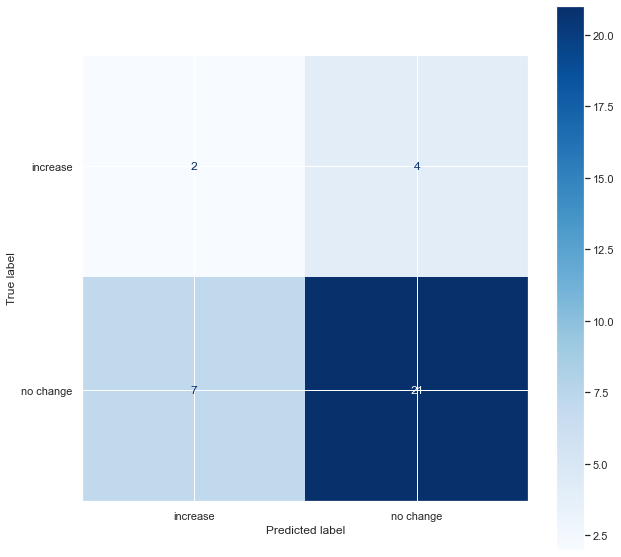

In [61]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [62]:
print(classification_report_imbalanced(y_test, y_pred,digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   increase     0.2222    0.3333    0.7500    0.2667    0.5000    0.2396         6
  no change     0.8400    0.7500    0.3333    0.7925    0.5000    0.2604        28

avg / total     0.7310    0.6765    0.4069    0.6997    0.5000    0.2567        34



<br>

The Naive Bayes model exhibits slightly less accuracy during the Janet Yellen tenure. Key highlights include
* precision for the no change class is over 0.8235
* recall and specificity are consistent across both classes present in the dataset


In [63]:
y_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
y_cl_df['fed_chair'] = 'Janet Yellen'
y_cl_df['model'] = 'Model 1: Naive Bayes'

In [64]:
cl_result_df = pd.concat([cl_result_df, y_cl_df])

<br><br>

#### Fed Chair Jerome H. Powell

Jerome Powell was appointed by Donald Trump and was Fed Chair since February 5, 2018. He has served just over 4 year of his term. This dataset is limited by the breadth of the Kaggle dataset used in this anlaysis.

In [65]:
powell_df = df_merge[df_merge['fed_chair'] == 'Jerome Powell']
powell_df['speaker'].value_counts(sort=True)

Vice Chair for Supervision Randal K. Quarles    37
Governor Lael Brainard                          34
Chairman Jerome H. Powell                       32
Vice Chairman Richard H. Clarida                26
Governor Michelle W. Bowman                     13
Name: speaker, dtype: int64

<br><br>

The impact of the pandemic on the economic system pushed the Fed to drop the funds rate back down to effectively zero in April of 2020.

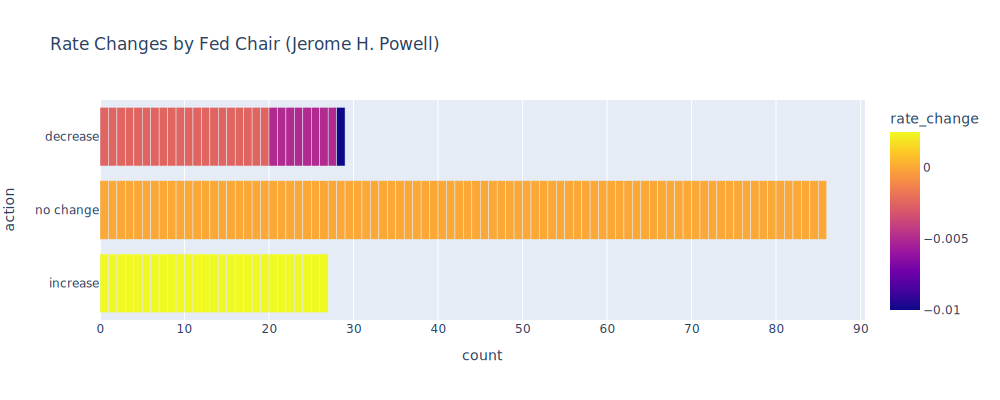

In [66]:
fig = px.bar(powell_df, y="action", color='rate_change', orientation='h',
             hover_data=["action", "rate_change"],
             width=1000, height=400, 
             title='Rate Changes by Fed Chair (Jerome H. Powell)')
fig.show(renderer='svg')

The analysis for Jerome Powell's tenure follows the same structure as the previous analysis.

In [67]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(powell_df['filter_text'], powell_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 64, 'decrease': 20, 'increase': 15})
Testing target statistics: Counter({'no change': 22, 'increase': 12, 'decrease': 9})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [68]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.2    0.3    0.5    0.5    0.6    0.1    0.3    0.6    0.4    0.3333]
Average 10-Fold CV Score: 0.3833


[[ 6  1  2]
 [ 8  3  1]
 [13  5  4]]


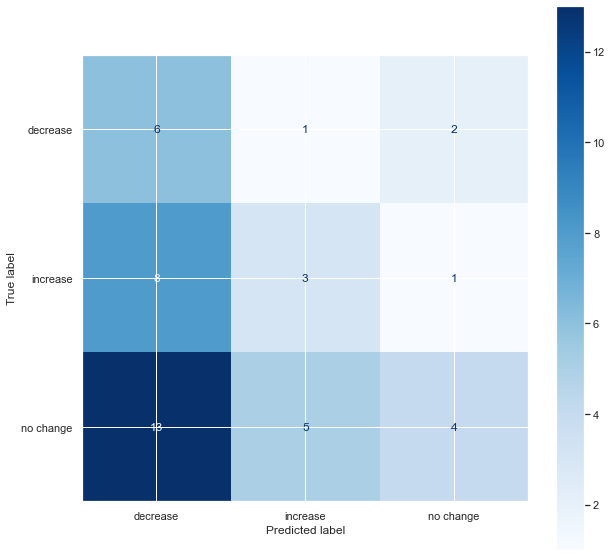

In [69]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [70]:
powell_imb_cl = classification_report_imbalanced(y_test, y_pred, digits=4)
print(powell_imb_cl)

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.2222    0.6667    0.3824    0.3333    0.5049    0.2621         9
   increase     0.3333    0.2500    0.8065    0.2857    0.4490    0.1904        12
  no change     0.5714    0.1818    0.8571    0.2759    0.3948    0.1453        22

avg / total     0.4319    0.3023    0.7436    0.2906    0.4330    0.1824        43



<br>

The Naive Bayes model exhibits limited accuracy during the Jerome Powell tenure. Key highlights include:
* precision for the no change class is just over 0.6364
* recall or the true positive rate is lower than the other measures of accuracy 
* specificity or the true negative measures are higher than the other measures of accuracy

In [71]:
p_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
p_cl_df['fed_chair'] = 'Jerome Powell'
p_cl_df['model'] = 'Model 1: Naive Bayes'

In [72]:
cl_result_df = pd.concat([cl_result_df, p_cl_df])

<br><br>

### Predict FOMC Rate Decision (DecisionTreeClassifier Sentiment Analysis)

This analysis utilizes the  Balanced Bagging ensemble Classifier in conjunction with the Decision Tree Classifier. To alleviate the model sensitivity to the training data we will utilize K-Folds method to cross validate the model performance. 

<br>

#### Fed Chair Alan Greenspan

To mitigate the impacts of this imbalance we will use a RandomUnderSampler to equalize the number of samples in all the classes before the training.

1. Split the dataset into training and testing
2. Initialize a vectorizer to create the BoW
3. Initialize the BalancedBaggingClassifier ensemble classifier
4. Initialize a imbalanced pipeline with the vectorizer, random sampler, and model
5. Fit the model
6. Generate measurements of model accuracy on the Training dataset
7. Predict Testing dataset
8. Generate measurement of model accuracy on the Test dataset


In [73]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['action'], random_state=23, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


# initialize a vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)


# initialize a DecisionTreeClassifier within a BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=RANDOM_STATE)


# initialize the imbalanced pipeline
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), bbc)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 232, 'increase': 130, 'decrease': 83})
Testing target statistics: Counter({'no change': 99, 'increase': 62, 'decrease': 30})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('balancedbaggingclassifier',
                 BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                           random_state=123))])

In [74]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.3556 0.1556 0.5333 0.4444 0.5333 0.1818 0.4318 0.5227 0.3864 0.5227]
Average 10-Fold CV Score: 0.4068


[[17  6  7]
 [12 34 16]
 [41 22 36]]


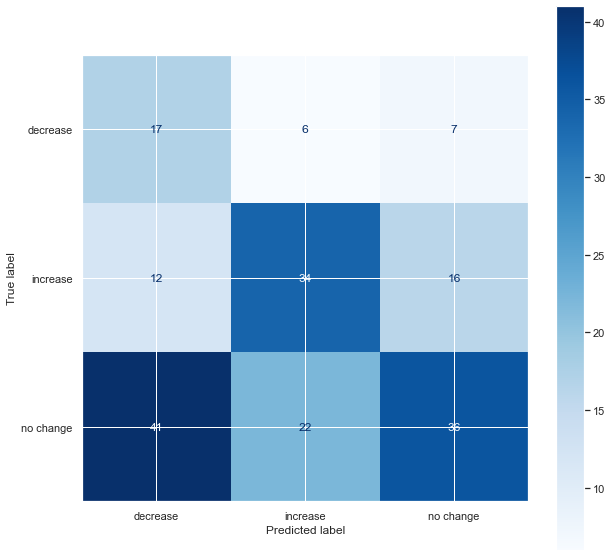

In [75]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [76]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.2429    0.5667    0.6708    0.3400    0.6165    0.3762        30
   increase     0.5484    0.5484    0.7829    0.5484    0.6553    0.4193        62
  no change     0.6102    0.3636    0.7500    0.4557    0.5222    0.2622        99

avg / total     0.5324    0.4555    0.7483    0.4676    0.5802    0.3311       191



<br>

The model based on an ensemble classifier produced slightly better accuracy than the Naive Bayes model. Key highlights include:
* precision for the no change class is just over 0.5904
* recall or the true positive rate is lower than the other measures of accuracy 
* specificity or the true negative measures are higher than the other measures of accuracy

In [77]:
a_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
a_cl_df['fed_chair'] = 'Alan Greenspan'
a_cl_df['model'] = 'Model 2: Ensemble - Decision Tree'

In [78]:
cl_result_df = pd.concat([cl_result_df, a_cl_df])

<br>

#### Fed Chair Ben S. Bernanke

The analysis for Ben Bernanke's tenure follows the same structure as the previous analysis.

In [79]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# initialize a vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)

# initialize a DecisionTreeClassifier within a BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=RANDOM_STATE)

# initialize pipline and fit model
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), bbc)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 308, 'decrease': 43, 'increase': 38})
Testing target statistics: Counter({'no change': 128, 'decrease': 23, 'increase': 16})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('balancedbaggingclassifier',
                 BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                           random_state=123))])

In [80]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.6154 0.5897 0.641  0.5385 0.6154 0.5385 0.7436 0.5897 0.5641 0.5526]
Average 10-Fold CV Score: 0.5989


[[16  6  1]
 [ 2 13  1]
 [20 36 72]]


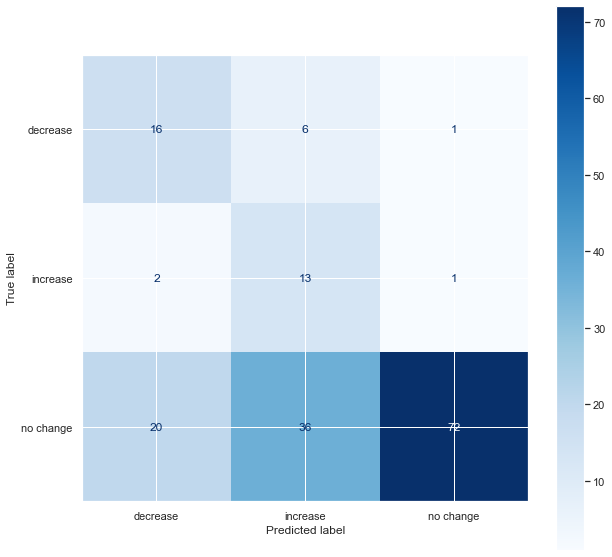

In [81]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [82]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.4211    0.6957    0.8472    0.5246    0.7677    0.5804        23
   increase     0.2364    0.8125    0.7219    0.3662    0.7658    0.5918        16
  no change     0.9730    0.5625    0.9487    0.7129    0.7305    0.5130       128

avg / total     0.8264    0.6048    0.9130    0.6537    0.7390    0.5299       167



<br>

The model based on an ensemble does not perform as well as the Naive Bayes model across all measures of accuracy. Key highlights include:
* precision for the no change class is lower than the accuracy from the naive bayes model. The change we caused by a decrease in prediction accuracy for the rate increase class
* recall or the true positive rate has a lower accuracy when compared to the naive bayes model
* specificity or the true negative measures is similar to the performance of the naive bayes model

In [83]:
b_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
b_cl_df['fed_chair'] = 'Ben Bernanke'
b_cl_df['model'] = 'Model 2: Ensemble - Decision Tree'

In [84]:
cl_result_df = pd.concat([cl_result_df, b_cl_df])

<br><br>


#### Fed Chair Janet L. Yellen

The analysis for Janet Yellen's tenure follows the same structure as the previous analysis.

In [85]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(yellen_df['filter_text'], yellen_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# initialize a vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)

# initialize a DecisionTreeClassifier within a BalancedBaggingClassifier 
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=RANDOM_STATE)

# initialize pipline and fit model
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), bbc)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 45, 'increase': 34})
Testing target statistics: Counter({'no change': 28, 'increase': 6})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('balancedbaggingclassifier',
                 BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                           random_state=123))])

In [86]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.625  0.     0.125  0.375  0.625  0.5    0.25   0.25   0.625  0.5714]
Average 10-Fold CV Score: 0.3946


[[ 2  4]
 [17 11]]


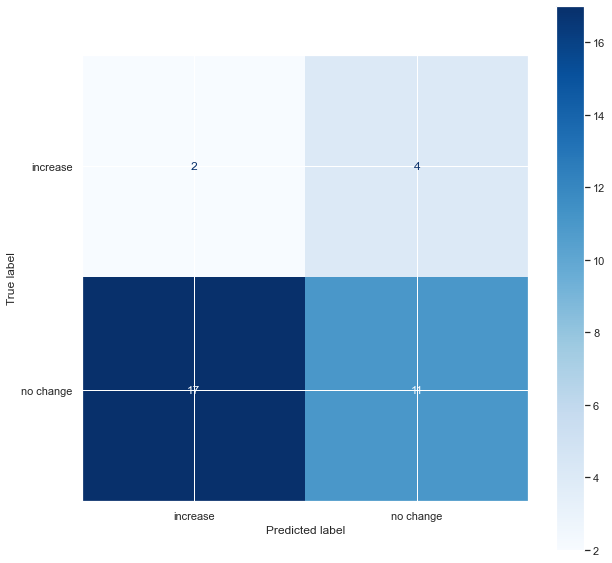

In [87]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [88]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   increase     0.1053    0.3333    0.3929    0.1600    0.3619    0.1302         6
  no change     0.7333    0.3929    0.3333    0.5116    0.3619    0.1317        28

avg / total     0.6225    0.3824    0.3438    0.4496    0.3619    0.1315        34



<br>

The model based on an ensemble is comparable but performs slightly worse than the Naive Bayes model across all measures of accuracy. Key highlights include:
* precision for the no change class is comparable with the naive bayes model
* recall or the true positive rate was much lower overall due to the fact that better performance in the rate increase class was more then offset with decreased performance of the rate no change class
* specificity or the true negative measures had the opposite impact when compared to the naive bayes model. The increase in the precision of the rate change class more than offset the decrease in precision of the increase class.

In [89]:
y_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
y_cl_df['fed_chair'] = 'Janet Yellen'
y_cl_df['model'] = 'Model 2: Ensemble - Decision Tree'

In [90]:
cl_result_df = pd.concat([cl_result_df, y_cl_df])

<br>

#### Fed Chair Jerome H. Powell

The analysis for Jerome Powell's tenure follows the same structure as the previous analysis.

In [91]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(powell_df['filter_text'], powell_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# initialize a vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)

# initialize a DecisionTreeClassifier within a BalancedBaggingClassifier  
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=RANDOM_STATE)


# initialize pipline and fit model
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), bbc)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 64, 'decrease': 20, 'increase': 15})
Testing target statistics: Counter({'no change': 22, 'increase': 12, 'decrease': 9})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('balancedbaggingclassifier',
                 BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                           random_state=123))])

In [92]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.4    0.5    0.2    0.2    0.3    0.2    0.3    0.4    0.3    0.1111]
Average 10-Fold CV Score: 0.2911


[[7 1 1]
 [4 5 3]
 [7 9 6]]


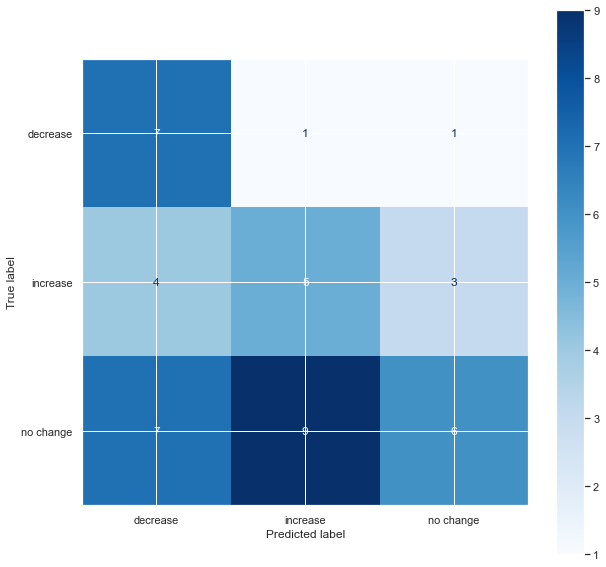

In [93]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [94]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.3889    0.7778    0.6765    0.5185    0.7254    0.5315         9
   increase     0.3333    0.4167    0.6774    0.3704    0.5313    0.2749        12
  no change     0.6000    0.2727    0.8095    0.3750    0.4699    0.2089        22

avg / total     0.4814    0.4186    0.7448    0.4037    0.5405    0.2948        43



<br>

The model based on an ensemble performs better overall than the Naive Bayes model for Jerome Powell's tenure. Key highlights include:
* higher precision for the no change class when comparable with the naive bayes model
* recall or the true positive rate was slightly lower overall
* specificity or the true negative measures performs better when compared to the naive bayes model.

In [95]:
p_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
p_cl_df['fed_chair'] = 'Jerome Powell'
p_cl_df['model'] = 'Model 2: Ensemble - Decision Tree'

In [96]:
cl_result_df = pd.concat([cl_result_df, p_cl_df])

<br><br>

### Predict FOMC Rate Decision (KNeighbors Classifier Sentiment Analysis)

As part of the analysis we classified the speeches by Federal Reserve governers using the K Nearest Neighbours classification model. We explored using the Radius Neighbors Classifier but the mdoel did not generate meaningful results.
 

<br>

#### Fed Chair Alan Greenspan

To mitigate the impacts of this imbalance we will use a RandomUnderSampler to equalize the number of samples in all the classes before the training. We also used the GridSearch package to optimize the n_neighbors paramater.

1. Split the dataset into training and testing
2. Initialize a vectorizer to create the BoW
3. Initialize the GridSearch object witht the KNN classifier
4. Initialize a imbalanced pipeline with the vectorizer, random sampler, and gridsearch
5. Fit the model
6. set n_neighbors
6. Generate measurements of model accuracy on the Training dataset
7. Predict Testing dataset
8. Generate measurement of model accuracy on the Test dataset

In [97]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 237, 'increase': 135, 'decrease': 73})
Testing target statistics: Counter({'no change': 94, 'increase': 57, 'decrease': 40})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [98]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 14}
0.47959830866807607


In [99]:
model.set_params(gridsearchcv__estimator__n_neighbors=14)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=KNeighborsClassifier(n_neighbors=11),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [100]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.4667 0.5111 0.2444 0.5333 0.4222 0.3409 0.4318 0.5455 0.1818 0.3864]
Average 10-Fold CV Score: 0.4064


[[17 10 13]
 [13 17 27]
 [25 21 48]]


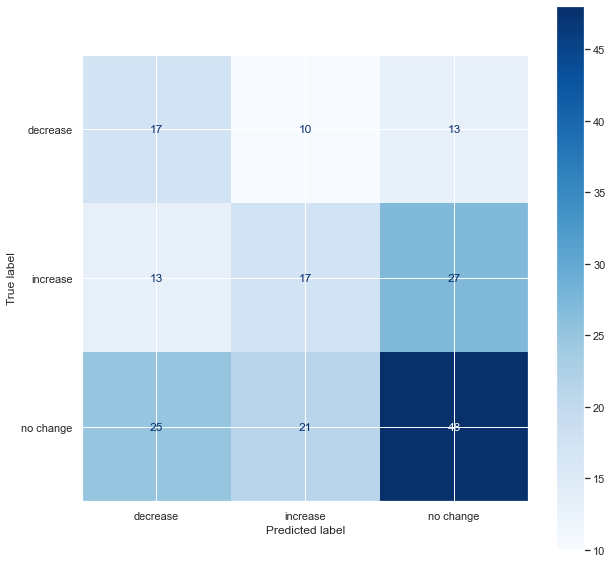

In [101]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [102]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.3091    0.4250    0.7483    0.3579    0.5640    0.3078        40
   increase     0.3542    0.2982    0.7687    0.3238    0.4788    0.2185        57
  no change     0.5455    0.5106    0.5876    0.5275    0.5478    0.2978        94

avg / total     0.4389    0.4293    0.6753    0.4312    0.5306    0.2762       191




The model performance is comparable to the naive bayes model but slightly less accurate than the ensemble classifier using a Decision Tree. Key highlights include:
* higher precision for the no change class when comparable with the naive bayes model
* recall or the true positive rate was slightly higher overall
* specificity or the true negative measures was less accurate compared to the naive bayes model.

In [103]:
a_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
a_cl_df['fed_chair'] = 'Alan Greenspan'
a_cl_df['model'] = 'Model 3: Ensemble - KNeighbors'

In [104]:
cl_result_df = pd.concat([cl_result_df, a_cl_df])

<br><br>

#### Fed Chair Ben S. Bernanke

The analysis for Ben Bernanke's tenure follows the same structure as the previous analysis.

In [105]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# initialize the Vectorizer and GridSearch
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

# initialize the imbalanced pipeline
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 308, 'decrease': 43, 'increase': 38})
Testing target statistics: Counter({'no change': 128, 'decrease': 23, 'increase': 16})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [106]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 3}
0.5177865612648221


In [107]:
model.set_params(gridsearchcv__estimator__n_neighbors=3)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=KNeighborsClassifier(n_neighbors=4),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [108]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.5641 0.5385 0.6154 0.6923 0.2821 0.5641 0.4872 0.4872 0.4615 0.4211]
Average 10-Fold CV Score: 0.5113


[[18  2  3]
 [ 7  9  0]
 [56 17 55]]


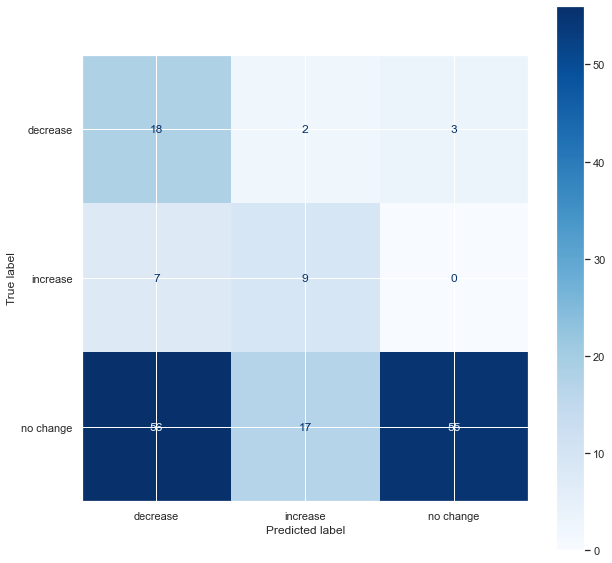

In [109]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [110]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   decrease     0.2222    0.7826    0.5625    0.3462    0.6635    0.4499        23
   increase     0.3214    0.5625    0.8742    0.4091    0.7012    0.4764        16
  no change     0.9483    0.4297    0.9231    0.5914    0.6298    0.3771       128

avg / total     0.7882    0.4910    0.8687    0.5402    0.6413    0.3966       167



The model performance is comparable to the naive bayes model but slightly less accurate than the ensemble classifier using a Decision Tree. Key highlights include:
* higher precision for the no change class when comparable with the naive bayes model
* recall or the true positive rate was slightly higher overall
* specificity or the true negative measures was less accurate compared to the naive bayes model.

In [111]:
b_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
b_cl_df['fed_chair'] = 'Ben Bernanke'
b_cl_df['model'] = 'Model 3: Ensemble - KNeighbors'

In [112]:
cl_result_df = pd.concat([cl_result_df, b_cl_df])

<br><br>

#### Fed Chair Janet L. Yellen

The analysis for Janet Yellen's tenure follows the same structure as the previous analysis.

In [113]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(yellen_df['filter_text'], yellen_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# initialize the Vectorizer and GridSearch
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

# initialize the imbalanced pipeline
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 45, 'increase': 34})
Testing target statistics: Counter({'no change': 28, 'increase': 6})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [114]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 11}
0.6032967032967033


In [115]:
model.set_params(gridsearchcv__estimator__n_neighbors=11)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=KNeighborsClassifier(n_neighbors=10),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [116]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.5    0.5    0.625  0.25   0.125  0.75   0.375  0.625  0.375  0.2857]
Average 10-Fold CV Score: 0.4411


[[ 3  3]
 [14 14]]


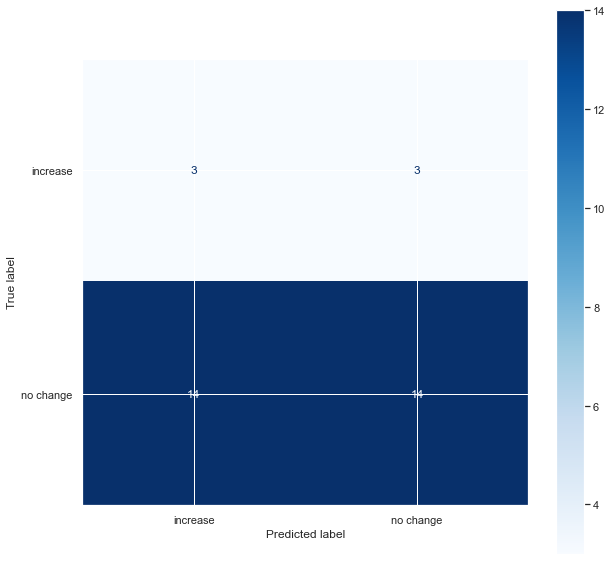

In [117]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [118]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

   increase     0.1765    0.5000    0.5000    0.2609    0.5000    0.2500         6
  no change     0.8235    0.5000    0.5000    0.6222    0.5000    0.2500        28

avg / total     0.7093    0.5000    0.5000    0.5585    0.5000    0.2500        34




The K Nearest Neighbours model's performance had the least percision of all three models. Key highlights include:
* larger gap between the percision accuracy of the rate no change classs and the rate increase class. 
* recall and specificity followed similar patterns

In [119]:
y_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
y_cl_df['fed_chair'] = 'Janet Yellen'
y_cl_df['model'] = 'Model 3: Ensemble - KNeighbors'

In [120]:
cl_result_df = pd.concat([cl_result_df, y_cl_df])

<br><br>

#### Fed Chair Jerome H. Powell

The analysis for Jerome Powell's tenure follows the same structure as the previous analysis.

In [121]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(powell_df['filter_text'], powell_df['action'], random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# initialize the Vectorizer and GridSearch
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

# initialize the imbalanced pipeline
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 64, 'decrease': 20, 'increase': 15})
Testing target statistics: Counter({'no change': 22, 'increase': 12, 'decrease': 9})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [122]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 2}
0.4


In [123]:
model.set_params(gridsearchcv__estimator__n_neighbors=2)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=KNeighborsClassifier(n_neighbors=16),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20]},
                              scoring='accuracy'))])

In [124]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.4    0.3    0.1    0.5    0.4    0.2    0.2    0.2    0.2    0.3333]
Average 10-Fold CV Score: 0.2833


[[ 4  4  1]
 [ 4  6  2]
 [12  4  6]]


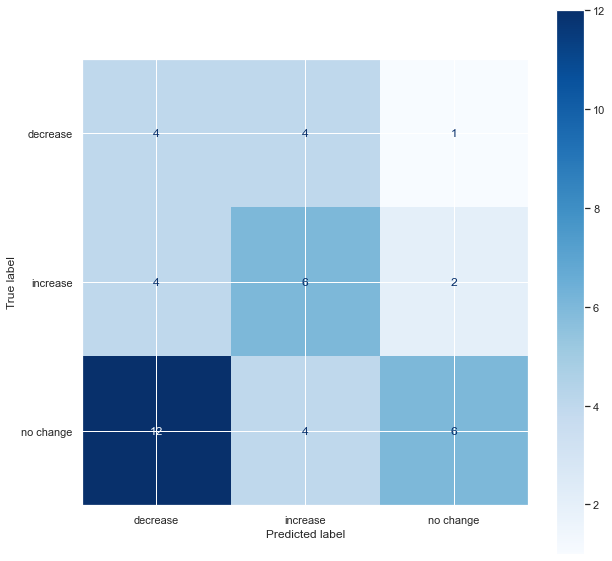

In [125]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [126]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

   decrease       0.20      0.44      0.53      0.28      0.49      0.23         9
   increase       0.43      0.50      0.74      0.46      0.61      0.36        12
  no change       0.67      0.27      0.86      0.39      0.48      0.22        22

avg / total       0.50      0.37      0.76      0.38      0.52      0.26        43



The K Nearest Neighbors model's performance had the least precision of all three models. Key highlights include:
* the precision was impacted by a high prediction of rate decrease classifications.  

In [127]:
p_cl_df = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, digits=4, output_dict=True))
p_cl_df['fed_chair'] = 'Jerome Powell'
p_cl_df['model'] = 'Model 3: Ensemble - KNeighbors'

In [128]:
cl_result_df = pd.concat([cl_result_df, p_cl_df])

<br><br>

## iNterpret

The table below captures the classification performance for each model segmented by Fed Chair. During the Ben Bernanke tenure the performance of all three models was higher than other Fed Chair tenure's.

In [129]:
pre_result_df = round(cl_result_df.loc['pre'].fillna(0),3)
pre_result_df.sort_values('avg_pre',ascending=False)

,decrease,increase,no change,avg_pre,avg_rec,avg_spe,avg_f1,avg_geo,avg_iba,total_support,fed_chair,model
pre,0.421,0.236,0.973,0.826,0.605,0.913,0.654,0.739,0.530,167,Ben Bernanke,Model 2: Ensemble - Decision Tree
pre,0.222,0.321,0.948,0.788,0.491,0.869,0.540,0.641,0.397,167,Ben Bernanke,Model 3: Ensemble - KNeighbors
pre,0.299,0.450,0.912,0.784,0.611,0.810,0.647,0.699,0.480,167,Ben Bernanke,Model 1: Naive Bayes
pre,0.000,0.222,0.840,0.731,0.676,0.407,0.700,0.500,0.257,34,Janet Yellen,Model 1: Naive Bayes
pre,0.000,0.176,0.824,0.709,0.500,0.500,0.558,0.500,0.250,34,Janet Yellen,Model 3: Ensemble - KNeighbors
pre,0.000,0.105,0.733,0.622,0.382,0.344,0.450,0.362,0.131,34,Janet Yellen,Model 2: Ensemble - Decision Tree
pre,0.243,0.548,0.610,0.532,0.455,0.748,0.468,0.580,0.331,191,Alan Greenspan,Model 2: Ensemble - Decision Tree
pre,0.200,0.429,0.667,0.503,0.372,0.756,0.385,0.519,0.262,43,Jerome Powell,Model 3: Ensemble - KNeighbors
pre,0.389,0.333,0.600,0.481,0.419,0.745,0.404,0.540,0.295,43,Jerome Powell,Model 2: Ensemble - Decision Tree
pre,0.176,0.424,0.581,0.466,0.482,0.632,0.460,0.498,0.252,191,Alan Greenspan,Model 1: Naive Bayes


<br>

The scatter plot below shows the aggregated performance for each Fed Chairs tenure. Based on the speeches by Fed Governors the three models performed the best overall during the Ben Bernanke tenure.

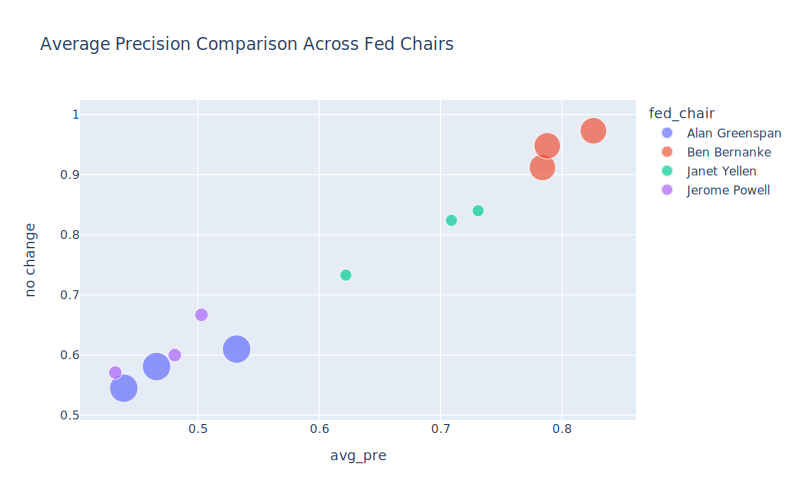

In [130]:
fig = px.scatter(pre_result_df, x="avg_pre", y="no change", size="total_support", color="fed_chair", 
                    hover_name="model", width=800, height=500, title="Average Precision Comparison Across Fed Chairs")
fig.show(renderer='svg')

<br>

If we decompose the performance by class predictions then the story around precision is a little mixed. During the Alen Greenspan tenure prediction of increase and Jerome Powell for decreases. 

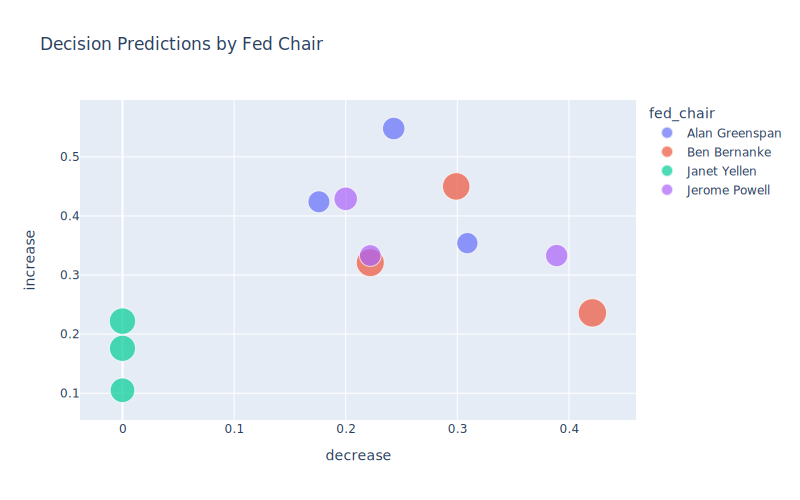

In [131]:
fig = px.scatter(pre_result_df, x="decrease", y="increase", size="no change", color="fed_chair", 
                    hover_name="fed_chair", width=800, height=500, title="Decision Predictions by Fed Chair")
fig.show(renderer='svg')

<b> 1. Across all three models speeches during Ben Bernanke's tenure provided the most insight into the upcoming FOMC decisions.

In [132]:
cl_result_df.groupby('fed_chair')['avg_pre','avg_rec','avg_spe'].agg([np.mean,min,max])

avg_pre                       avg_rec                      \
                    mean       min       max      mean       min       max   
fed_chair                                                                    
Alan Greenspan  0.479228  0.438868  0.532421  0.455497  0.429319  0.481675   
Ben Bernanke    0.799412  0.783627  0.826387  0.568862  0.491018  0.610778   
Janet Yellen    0.687607  0.622497  0.730980  0.519608  0.382353  0.676471   
Jerome Powell   0.471945  0.431894  0.502547  0.364341  0.302326  0.418605   

                 avg_spe                      
                    mean       min       max  
fed_chair                                     
Alan Greenspan  0.685158  0.631907  0.748256  
Ben Bernanke    0.864078  0.810498  0.913004  
Janet Yellen    0.416900  0.343838  0.500000  
Jerome Powell   0.748276  0.743622  0.756397

<br>

<b> 2. Across all models speeches during the Alen Greenspan and the Jerome Powell tenures provided the least predictive power

In [133]:
cl_result_df.groupby('fed_chair')['avg_pre','avg_rec','avg_spe'].agg([np.mean,min,max])

avg_pre                       avg_rec                      \
                    mean       min       max      mean       min       max   
fed_chair                                                                    
Alan Greenspan  0.479228  0.438868  0.532421  0.455497  0.429319  0.481675   
Ben Bernanke    0.799412  0.783627  0.826387  0.568862  0.491018  0.610778   
Janet Yellen    0.687607  0.622497  0.730980  0.519608  0.382353  0.676471   
Jerome Powell   0.471945  0.431894  0.502547  0.364341  0.302326  0.418605   

                 avg_spe                      
                    mean       min       max  
fed_chair                                     
Alan Greenspan  0.685158  0.631907  0.748256  
Ben Bernanke    0.864078  0.810498  0.913004  
Janet Yellen    0.416900  0.343838  0.500000  
Jerome Powell   0.748276  0.743622  0.756397

<br>

<b>3. All three models generated comparable results.

In [134]:
cl_result_df.loc['pre'].pivot_table(values=['avg_pre','no change','increase','decrease'], index=['model','fed_chair'], aggfunc=[np.mean,min,max])

mean            \
                                                   avg_pre  decrease   
model                             fed_chair                            
Model 1: Naive Bayes              Alan Greenspan  0.466393  0.176471   
                                  Ben Bernanke    0.783627  0.298507   
                                  Janet Yellen    0.730980       NaN   
                                  Jerome Powell   0.431894  0.222222   
Model 2: Ensemble - Decision Tree Alan Greenspan  0.532421  0.242857   
                                  Ben Bernanke    0.826387  0.421053   
                                  Janet Yellen    0.622497       NaN   
                                  Jerome Powell   0.481395  0.388889   
Model 3: Ensemble - KNeighbors    Alan Greenspan  0.438868  0.309091   
                                  Ben Bernanke    0.788223  0.222222   
                                  Janet Yellen    0.709343       NaN   
                                  Jerome Powell   0.502547  0.200000   

                                                                      \
                                                  increase no change   
model                             fed_chair                            
Model 1: Naive Bayes              Alan Greenspan  0.424242  0.580645   
                                  Ben Bernanke    0.450000  0.912500   
                                  Janet Yellen    0.222222  0.840000   
                                  Jerome Powell   0.333333  0.571429   
Model 2: Ensemble - Decision Tree Alan Greenspan  0.548387  0.610169   
                                  Ben Bernanke    0.236364  0.972973   
                                  Janet Yellen    0.105263  0.733333   
                                  Jerome Powell   0.333333  0.600000   
Model 3: Ensemble - KNeighbors    Alan Greenspan  0.354167  0.545455   
                                  Ben Bernanke    0.321429  0.948276   
                                  Janet Yellen    0.176471  0.823529   
                                  Jerome Powell   0.428571  0.666667   

                                                       min            \
                                                   avg_pre  decrease   
model                             fed_chair                            
Model 1: Naive Bayes              Alan Greenspan  0.466393  0.176471   
                                  Ben Bernanke    0.783627  0.298507   
                                  Janet Yellen    0.730980       NaN   
                                  Jerome Powell   0.431894  0.222222   
Model 2: Ensemble - Decision Tree Alan Greenspan  0.532421  0.242857   
                                  Ben Bernanke    0.826387  0.421053   
                                  Janet Yellen    0.622497       NaN   
                                  Jerome Powell   0.481395  0.388889   
Model 3: Ensemble - KNeighbors    Alan Greenspan  0.438868  0.309091   
                                  Ben Bernanke    0.788223  0.222222   
                                  Janet Yellen    0.709343       NaN   
                                  Jerome Powell   0.502547  0.200000   

                                                                      \
                                                  increase no change   
model                             fed_chair                            
Model 1: Naive Bayes              Alan Greenspan  0.424242  0.580645   
                                  Ben Bernanke    0.450000  0.912500   
                                  Janet Yellen    0.222222  0.840000   
                                  Jerome Powell   0.333333  0.571429   
Model 2: Ensemble - Decision Tree Alan Greenspan  0.548387  0.610169   
                                  Ben Bernanke    0.236364  0.972973   
                                  Janet Yellen    0.105263  0.733333   
                                  Jerome Powell   0.333333  0.600000   
Model 3: Ensemble -

<br>

<b> 4. All three models predict the rate no change classification with higher percision than the rate increase or the rate decrease classification. 

In [135]:
cl_result_df.pivot_table(values=['avg_pre','avg_rec','avg_spe'], index=['fed_chair','model'], aggfunc=[np.mean,min,max])

mean            \
                                                   avg_pre   avg_rec   
fed_chair      model                                                   
Alan Greenspan Model 1: Naive Bayes               0.466393  0.481675   
               Model 2: Ensemble - Decision Tree  0.532421  0.455497   
               Model 3: Ensemble - KNeighbors     0.438868  0.429319   
Ben Bernanke   Model 1: Naive Bayes               0.783627  0.610778   
               Model 2: Ensemble - Decision Tree  0.826387  0.604790   
               Model 3: Ensemble - KNeighbors     0.788223  0.491018   
Janet Yellen   Model 1: Naive Bayes               0.730980  0.676471   
               Model 2: Ensemble - Decision Tree  0.622497  0.382353   
               Model 3: Ensemble - KNeighbors     0.709343  0.500000   
Jerome Powell  Model 1: Naive Bayes               0.431894  0.302326   
               Model 2: Ensemble - Decision Tree  0.481395  0.418605   
               Model 3: Ensemble - KNeighbors     0.502547  0.372093   

                                                                 min  \
                                                   avg_spe   avg_pre   
fed_chair      model                                                   
Alan Greenspan Model 1: Naive Bayes               0.631907  0.466393   
               Model 2: Ensemble - Decision Tree  0.748256  0.532421   
               Model 3: Ensemble - KNeighbors     0.675311  0.438868   
Ben Bernanke   Model 1: Naive Bayes               0.810498  0.783627   
               Model 2: Ensemble - Decision Tree  0.913004  0.826387   
               Model 3: Ensemble - KNeighbors     0.868731  0.788223   
Janet Yellen   Model 1: Naive Bayes               0.406863  0.730980   
               Model 2: Ensemble - Decision Tree  0.343838  0.622497   
               Model 3: Ensemble - KNeighbors     0.500000  0.709343   
Jerome Powell  Model 1: Naive Bayes               0.743622  0.431894   
               Model 2: Ensemble - Decision Tree  0.744809  0.481395   
               Model 3: Ensemble - KNeighbors     0.756397  0.502547   

                                                                      \
                                                   avg_rec   avg_spe   
fed_chair      model                                                   
Alan Greenspan Model 1: Naive Bayes               0.481675  0.631907   
               Model 2: Ensemble - Decision Tree  0.455497  0.748256   
               Model 3: Ensemble - KNeighbors     0.429319  0.675311   
Ben Bernanke   Model 1: Naive Bayes               0.610778  0.810498   
               Model 2: Ensemble - Decision Tree  0.604790  0.913004   
               Model 3: Ensemble - KNeighbors     0.491018  0.868731   
Janet Yellen   Model 1: Naive Bayes               0.676471  0.406863   
               Model 2: Ensemble - Decision Tree  0.382353  0.343838   
               Model 3: Ensemble - KNeighbors     0.500000  0.500000   
Jerome Powell  Model 1: Naive Bayes               0.302326  0.743622   
               Model 2: Ensemble - Decision Tree  0.418605  0.744809   
               Model 3: Ensemble - KNeighbors     0.372093  0.756397   

                                                       max                      
                                                   avg_pre   avg_rec   avg_spe  
fed_chair      model                                                            
Alan Greenspan Model 1: Naive Bayes               0.466393  0.481675  0.631907  
               Model 2: Ensemble - Decision Tree  0.532421  0.455497  0.748256  
               Model 3: Ensemble - KNeighbors     0.438868  0.429319  0.675311  
Ben Bernanke   Model 1: Naive Bayes               0.783627  0.610778  0.810498  
               Model 2: Ensemble - Decision Tree  0.826387  0.604790  0.913004  
               Model 3: Ensemble - KNeighbors     0.788223  0.491018  0.868731  
Janet Yellen   Model 1: Naive Bayes               0.730980  0.676471  0.406863  
 

<br>

<b> 5. All three models demostrated limited ability to predict the magnitued of a rate no change. 

In [136]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=RANDOM_STATE, test_size=0.3)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

# define vectorizer and model pipeline
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())

_none = model.fit(X_train, y_train)

Training target statistics: Counter({'0.0': 308, '0.0025': 33, '-0.0025': 25, '-0.0075': 16, '-0.005': 7})
Testing target statistics: Counter({'0.0': 128, '0.0025': 14, '-0.0025': 10, '-0.0075': 9, '-0.005': 6})


In [137]:
cv_results = cross_val_score(model, X_train, y_train, cv=5)
print('Cross Validation Score:', np.round(cv_results,4))
print("Average 10-Fold CV Score:", round(np.mean(cv_results),4))

Cross Validation Score: [0.1538 0.2564 0.1154 0.0897 0.0909]
Average 10-Fold CV Score: 0.1413


[[ 4  1  4  0  1]
 [ 1  4  1  0  0]
 [ 3  4  2  0  0]
 [11 51 50 11  5]
 [ 2  3  4  0  5]]


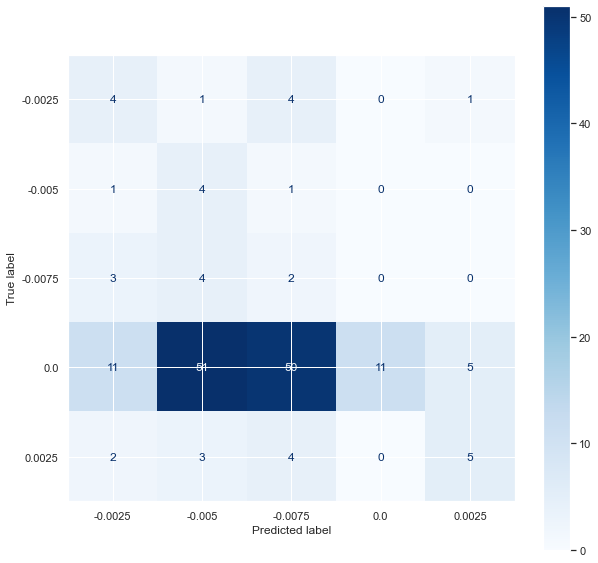

In [138]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [139]:
print(classification_report_imbalanced(y_test, y_pred, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

    -0.0025     0.1905    0.4000    0.8917    0.2581    0.5972    0.3391        10
     -0.005     0.0635    0.6667    0.6335    0.1159    0.6499    0.4238         6
    -0.0075     0.0328    0.2222    0.6266    0.0571    0.3731    0.1336         9
        0.0     1.0000    0.0859    1.0000    0.1583    0.2932    0.0781       128
     0.0025     0.4545    0.3571    0.9608    0.4000    0.5858    0.3224        14

avg / total     0.8200    0.1557    0.9569    0.1775    0.3530    0.1296       167



<br><br>

# 3. Conclusion

All three models support the alternate hypothesis. The speeches by Federal Reserve Governors did a better job forecasting the FOMC decision during the Ben Bernanke and Janet Yellen tenure when compared to Alan Greenspan's term as Fed Chair. 

The Ben Bernanke and Jerome Powell terms as Fed Chair were marked by economic turmoil that altered the central behavior. During those two periods the Federal Reserve engaged in extraordinary actions to conduct monetary policy and protect the economy. This likely translates into lower prediction accuracy for the rate increase and rate decrease classes. 

Although the first 2 models have a relatively high precision accuracy the overall value of the analysis is limited by the lower accuracy for predicting rate changes. 


Areas of additional study include:
* impact of political environment on the speeches by Fed Governors. There was a level of trust in the Fed during the tenure of Alan Greenspan. There were comments about the Greenspan put and faith that there would be a soft landing for any market turbulence. During the Trump presidency the Federal Reserve and its monitory policy became part of the political discourse.
* understand the impact of Federal Reserve rate that is effectively zero. It might be worth isolating those time periods from the general analysis
* including the proximity of a speech to the FOMC meeting in the analysis might provide some additional insights. 